In [6]:
%pylab inline

from __future__ import (division, print_function)

import os
import sys
import copy
import fnmatch
import warnings
import collections

import numpy as np
import scipy
try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar

# AstroML
from astroML.plotting import hist
from astroML.density_estimation import KNeighborsDensity
try:
    from sklearn.neighbors import KernelDensity
    use_sklearn_KDE = True
except:
    import warnings
    warnings.warn("KDE will be removed in astroML version 0.3.  Please "
                  "upgrade to scikit-learn 0.14+ and use "
                  "sklearn.neighbors.KernelDensity.", DeprecationWarning)
    from astroML.density_estimation import KDE
    use_sklearn_KDE = False
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree

# Matplotlib related
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5

# Personal
import hscUtils as hUtil
import galSBP
import coaddCutoutGalfitSimple as gSimple 

import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)

# Color map 
from palettable.colorbrewer.sequential import Oranges_4
ORG4 = Oranges_4.mpl_colormap

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# Absolute magnitude of sun in HSC filters

# Actuall borrowed from DES filters
# Values from magsun.data in FSPS
amag_sun_des_g = 5.08
amag_sun_des_r = 4.62
amag_sun_des_i = 4.52
amag_sun_des_z = 4.52
amag_sun_des_y = 4.51

# Based on http://www.baryons.org/ezgal/filters.php
amag_sun_ukiss_y = 4.515

# Extinction correction factor for HSC 
## A\_lambda = Coeff * E(B-V) 

a_hsc_g = 3.233
a_hsc_r = 2.291 
a_hsc_i = 1.635
a_hsc_z = 1.261
a_hsc_y = 1.076

# 
SIGMA1 = 0.3173
SIGMA2 = 0.0455
SIGMA3 = 0.0027

RSMA_COMMON = np.arange(0.4, 4.2, 0.02)

### Fancy one 
# definitions for the axes
left, width    = 0.12, 0.69
right          = left + width 
bottom, height = 0.12, 0.86
bottom_h = left_h = left + width + 0.02

recScat = [left,   bottom, width, height]
recHist = [right,  bottom,  0.18, height]

SBP1 = [0.122, 0.066, 0.872, 0.320]
SBP2 = [0.122, 0.386, 0.872, 0.585]

# Color 
BLUE0 = "#92c5de"
BLUE1 = "#0571b0"

RED0 = "#f4a582"
RED1 = "#ca0020"

PURPLE0 = '#af8dc3'
PURPLE1 = '#762a83'

BROWN0 = '#bf812d'
BROWN1 = '#543005'

GREEN0 = '#7fbf7b'
GREEN1 = '#1b7837'

In [3]:
# Code for Get Bootstrap mean or median 
def _confidence_interval_1d(A, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    """Calculates bootstrap confidence interval along one dimensional array"""
    
    if not isinstance(alpha, collections.Iterable):
        alpha = np.array([alpha])

    N = len(A)
    resampleInds = np.random.randint(0, N, (numResamples,N))
    metricOfResampled = metric(A[resampleInds], axis=-1)

    confidenceInterval = np.zeros(2*len(alpha),dtype='float')
    
    if interpolate:
        for thisAlphaInd, thisAlpha in enumerate(alpha):
            confidenceInterval[2*thisAlphaInd] = scoreatpercentile(metricOfResampled, 
                                                                   thisAlpha*100/2.0)
            confidenceInterval[2*thisAlphaInd+1] = scoreatpercentile(metricOfResampled, 
                                                                     100-thisAlpha*100/2.0)
    else:
        sortedMetricOfResampled = np.sort(metricOfResampled)
        for thisAlphaInd, thisAlpha in enumerate(alpha):
            confidenceInterval[2*thisAlphaInd] = sortedMetricOfResampled[int(round(thisAlpha*numResamples/2.0))]
            confidenceInterval[2*thisAlphaInd+1] = sortedMetricOfResampled[int(round(numResamples - 
                                                                                     thisAlpha*numResamples/2.0))]
    return confidenceInterval
    
def _ma_confidence_interval_1d(A, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    A = np.ma.masked_invalid(A, copy=True)
    A = A.compressed()
    confidenceInterval = _confidence_interval_1d(A, alpha, metric, numResamples, interpolate)
    return confidenceInterval

def confidence_interval(A, axis=None, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    """Return the bootstrap confidence interval of an array or along an axis ignoring NaNs and masked elements.
    
    Parameters
    ----------
    A : array_like
        Array containing numbers whose confidence interval is desired. 
    axis : int, optional
        Axis along which the confidence interval is computed.
        The default is to compute the confidence interval of the flattened array.
    alpha: float or array, optional
        confidence level of confidence interval. 100.0*(1-alpha) percent confidence 
        interval will be returned.
        If length-n array, n confidence intervals will be computed
        The default is .05
    metric : numpy function, optional
        metric to calculate confidence interval for.
        The default is numpy.mean
    numResamples : int, optional
        number of bootstrap samples. The default is 10000.
    interpolate: bool, optional
        uses scipy.stats.scoreatpercentile to interpolate between bootstrap samples 
        if alpha*numResamples/2.0 is not integer.
        The default is True
        
    Returns
    -------
    confidenceInterval : ndarray
    An array with the same shape as `A`, with the specified axis replaced by one twice the length of the alpha
    If `A` is a 0-d array, or if axis is None, a length-2 ndarray is returned.
    """
    if interpolate is True and scoreatpercentile is False:
        print("need scipy to interpolate between values")
        interpolate = False
    A = A.copy()
    if axis is None:
        A = A.ravel()
        outA = _ma_confidence_interval_1d(A, alpha, metric, numResamples, interpolate)
    else:
        outA = np.apply_along_axis(_ma_confidence_interval_1d, axis, A, alpha, 
                                   metric, numResamples, interpolate)
        
    return outA

def normProf(sma, sbp, minSma, maxSma, divide=False): 
    """
    Naive method to normalize the profile. 
    
    Parameters: 
        sbp    : Array for surface brightness profile 
        sma    : Radius range 
        minSma : Minimum SMA
        maxSma   Maximum SMA
    """
    offset = np.nanmedian(sbp[(sma >= minSma) & 
                              (sma <= maxSma)])
    if divide: 
        return (sbp / offset)
    else:
        return (sbp-offset)
    
    
def pixKpc(redshift, pix=0.168, show=True, npix=1.0):
    """
    Get the corresponding Kpc size of a pixel.  
    
    Parameters: 
    """
    pixKpc = pix * npix * hUtil.cosmoScale(redshift)

    if show:
        print("# %d pixel(s) = %6.3f Kpc" % (npix, pixKpc))
        
    return pixKpc


def logAdd(para1, para2):
    """ Useful for adding magnitudes. """
    return np.log10((10.0 ** np.asarray(para1)) + 
                    (10.0 ** np.asarray(para2)))


def errAdd(err1, err2):
    """Add error quadral..."""
    return np.sqrt((err1 ** 2.0) + 
                   (err2 ** 2.0))


def toColorArr(data, bottom=None, top=None):
    """ 
    Convert a data array to "color array" (between 0 and 1). 
    
    Parameters:
        bottom, top  : 
    """
    if top is not None:
        data[data >= top] = top
    if bottom is not None:
        data[data <= bottom] = bottom
        
    return ((data - np.nanmin(data)) / 
            (np.nanmax(data) - np.nanmin(data))) * 255.0


def getLuminosity(mag, redshift, extinction=None, 
                  amag_sun=None):
    """Get the absolute magnitude or luminosity."""
    distmod = hUtil.cosmoDistMod(redshift)
    absMag = (mag - distmod)
    if extinction is not None: 
        absMag -= extinction 
    if amag_sun is not None: 
        absMag = ((amag_sun - absMag) / 2.5)
    
    return absMag

def getStackProfiles(sample, loc, name='GAMA', 
                     idCol='ID_USE', tabCol='sum_tab', save=True):
    """Get the stacks of the profiles."""
    print("## Sample %s : Will deal with %d galaxies" % (name, len(sample)))
    profiles = []
    with ProgressBar(len(sample), ipython_widget=True) as bar:
        for g in sample:
            try:
                gFile = os.path.join(loc, g['sum_tab'].replace('./', '')).strip()
                gProf = Table.read(gFile, format='fits')
                """ Add extra information """
                try: 
                    gProf.meta['KCORRECT_I'] = g['KCORRECT_I']
                    gProf.meta['KCORRECT_b_I'] = g['KCORRECT_b_I']
                    gProf.meta['KCORRECT_c_I'] = g['KCORRECT_c_I']
                    gProf.meta['KCORRECT_G'] = g['KCORRECT_G']
                    gProf.meta['KCORRECT_b_G'] = g['KCORRECT_b_G']
                    gProf.meta['KCORRECT_c_G'] = g['KCORRECT_c_G']
                    gProf.meta['KCORRECT_R'] = g['KCORRECT_R']
                    gProf.meta['KCORRECT_b_R'] = g['KCORRECT_b_R']
                    gProf.meta['KCORRECT_c_R'] = g['KCORRECT_c_R']
                    gProf.meta['KCORRECT_Z'] = g['KCORRECT_Z']
                    gProf.meta['KCORRECT_b_Z'] = g['KCORRECT_b_Z']
                    gProf.meta['KCORRECT_c_Z'] = g['KCORRECT_c_Z']
                    gProf.meta['KCORRECT_Y'] = g['KCORRECT_Y']
                    gProf.meta['KCORRECT_b_Y'] = g['KCORRECT_b_Y']
                    gProf.meta['KCORRECT_c_Y'] = g['KCORRECT_c_Y']
                    gProf.meta['LOGM2LI_A'] = g['logm2lI_A']
                    gProf.meta['LOGM2LI_B'] = g['logm2lI_B']
                    gProf.meta['LOGM2LI_C'] = g['logm2lI_C']
                    gProf.meta['LUM_100'] = g['lum_100']
                    gProf.meta['LUM_120'] = g['lum_120']
                except Exception:
                    print("## WARNING: Some metadata may not be available !")
                    continue
            except Exception:
                print("## Missing: %s" % gFile)
                continue 
            profiles.append(gProf)
            bar.update()
    
    if save: 
        outPkl = os.path.join(loc, (name + '_profs.pkl'))
        hUtil.saveToPickle(profiles, outPkl)
        print("## Save %s to %s" % (name, outPkl))
        
    return profiles


def organizeSbp(profiles, col1='muI1', col2='KCORRECT_c_I', 
                kind='sbp', norm=False, r1=9.9, r2=10.1, divide=False,
                col3=None, col4=None, justStack=False,
                sun1=amag_sun_des_g, sun2=amag_sun_des_r,
                index=None):
    """ Get the stack of individual profiels, and their med/avg. """
    if kind.strip() == 'sbp':
        if col2 is not None: 
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(p[col1] + (p.meta[col2] / 2.5)), 
                                           r1, r2, divide=divide) 
                                  for p in profiles)
            else:
                stack = np.vstack(np.asarray(p[col1] + (p.meta[col2] / 2.5)) 
                                  for p in profiles)
        else: 
            print("## NO KCORRECTION APPLIED !!")            
            if norm:
                stack = np.vstack(normProf(p['rKpc'], p[col1], 
                                           r1, r2, divide=divide) 
                                  for p in profiles)
            else:
                stack = np.vstack(np.asarray(p[col1]) for p in profiles)
    elif kind.strip() == 'mass':
        if norm:
            stack = np.vstack(normProf(p['rKpc'], 
                                       np.asarray(p[col1] + p.meta[col2]), 
                                       r1, r2, divide=divide) for p in profiles)
        else: 
            stack = np.vstack(np.asarray(p[col1] + p.meta[col2]) for p in profiles)
    elif kind.strip() == 'color':
        cSun = (sun1 - sun2)
        if col3 is None or col4 is None:
            print("## NO KCORRECTION APPLIED !!")
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(cSun - 2.5 * (p[col1] - p[col2])), 
                                           r1, r2, divide=divide) for p in profiles)
            else: 
                stack = np.vstack(np.asarray(cSun - 2.5 *(p[col1] - p[col2])) for p in profiles)
        else:
            if norm:
                stack = np.vstack(normProf(p['rKpc'], 
                                           np.asarray(cSun - 2.5 * (p[col1] - p[col2]) -
                                                      (p.meta[col3] - p.meta[col4])), 
                                           r1, r2, divide=divide) for p in profiles)
            else: 
                stack = np.vstack(np.asarray(cSun - 2.5 * (p[col1] - p[col2]) -
                                             (p.meta[col3] - p.meta[col4])) 
                                  for p in profiles)
    elif kind.strip() == 'lum':
        if col2 is None:
            stack = np.vstack(np.asarray(p[col1]) for p in profiles)
        else:
            stack = np.vstack(np.asarray(p[col1] - p.meta[col2]) for p in profiles)
    else: 
        raise Exception("## WRONG KIND !!")
        
    if index is not None: 
        stack = np.vstack(p[index] for p in stack)
        
    if not justStack:
        """ Get the median and 1-sigma confidence range """
        medProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanmedian, numResamples=1000, 
                                      interpolate=True) 
        avgProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanmean, numResamples=1000, 
                                      interpolate=True) 
        stdProf = confidence_interval(stack, axis=0, alpha=np.asarray([SIGMA1, 1.0]), 
                                      metric=np.nanstd, numResamples=1000, 
                                      interpolate=True) 
        return stack, medProf, avgProf, stdProf
    else: 
        return stack
    

def loadPkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle
    
    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)    
        pklFile.close()
    
        return data
    else: 
        warnings.warn("## Can not find %s, return None" % filename)
        return None

In [4]:
newDir = '/Users/songhuang/work/hscs/gama_massive/sbp/'

bcgFile = 'redbcg_1d_160211.fits'
memFile = 'redmem_1d_160211.fits'
gamaFile = 'gama_1d_160211.fits'

try:
    bcgTab
except NameError:
    pass
else:
    del bcgTab
    
try:
    memTab
except NameError:
    pass
else:
    del memTab    
    
try:
    gamaTab
except NameError:
    pass
else:
    del gamaTab
    
#
bcgDir = os.path.join(newDir, 'redbcg')
memDir = os.path.join(newDir, 'redmem')
gamaDir = os.path.join(newDir, 'gama')

# Two summary catalogs
bcgCat = os.path.join(newDir, bcgFile)
memCat = os.path.join(newDir, memFile)
gamaCat = os.path.join(newDir, gamaFile)

if not os.path.isfile(bcgCat):
    raise Exception("## Can not find catalog for BCGs : %s" % bcgCat)
else: 
    bcgTab = Table.read(bcgCat, format='fits')

if not os.path.isfile(memCat):
    raise Exception("## Can not find catalog for cluster members : %s" % memCat)
else: 
    memTab = Table.read(memCat, format='fits')
    
if not os.path.isfile(gamaCat):
    raise Exception("## Can not find catalog for GAMA galaxies : %s" % gamaCat)
else: 
    gamaTab = Table.read(gamaCat, format='fits')
    
print("## Deal with %i galaxies in redBCH sample" % len(bcgTab))
print("## Deal with %i galaxies in redMEM sample" % len(memTab))
print("## Deal with %i galaxies in GAMA sample" % len(gamaTab))

## Deal with 219 galaxies in redBCH sample
## Deal with 1670 galaxies in redMEM sample
## Deal with 9212 galaxies in GAMA sample


# Get a "Clean" GAMA sample 

In [5]:
bcgClean = bcgTab[(bcgTab['m100_c'] >= 10.0) & 
                  (bcgTab['c82_120'] <= 14.0) &
                  (bcgTab['r90_max'] <= 160.0)]
print(len(bcgClean))

gamaClean = gamaTab[(gamaTab['c82_120'] >= 5.0) & 
                    (gamaTab['c82_120'] <= 14.0) &
                    (gamaTab['gz_kC'] >= 1.50) &
                    (gamaTab['ur_rest_sed'] >= 2.1) & 
                    (gamaTab['m100_c'] >= 10.0) &
                    (gamaTab['r90_max'] <= 160.0) &
                    ((gamaTab['r50_120'] - gamaTab['r20_120']) >= 
                     (32.0 * (gamaTab['m30_c'] - gamaTab['m10_c']) - 1.4) )]

print(len(gamaClean))

memClean = memTab[(memTab['c82_120'] >= 5.0) &
                  (memTab['c82_120'] <= 14.0) &
                  (memTab['gz_kC'] >= 1.5) &
                  (memTab['ur_rest_sed'] >= 2.1) & 
                  (memTab['m100_c'] >= 10.0) &
                  (memTab['r90_max'] <= 160.0) &
                  ((memTab['r50_120'] - memTab['r20_120']) >= 
                   (32.0 * (memTab['m30_c'] - memTab['m10_c']) - 1.4) )]
print(len(memClean))

174
4102
236


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater_equal


In [93]:
bcgMErr = np.sqrt(((bcgClean['MSTAR'] - bcgClean['MSTAR_c']) / 4.0 ** 2.0) + (bcgClean['MSTAR_ERR'] ** 2.0))
bcgMErr = np.asarray(bcgMErr)
bcgMErr[bcgMErr <= 0.06] = 0.065

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


# Whole Sample; Using M100

## Using Mass Model C;  0.2 < z < 0.5;  Lambda > 30

In [65]:
# Sample Matching Using K-Dtree

## Mass and Redshift Limit 
mlim0, mlim1 = 11.45, 11.95
zlim0, zlim1 = 0.20, 0.48
lamLimit = 30
pcenLimit = 0.8

## BCG sample used for matching
bcgUse = bcgClean[(bcgClean['m100_c'] >= mlim0) & 
                  (bcgClean['m100_c'] <= mlim1) & 
                  (bcgClean['z_use'] >= zlim0) &
                  (bcgClean['z_use'] <= zlim1) &
                  (bcgClean['LAMBDA_CLUSTER'] >= lamLimit) &
                  (bcgClean['P_CEN_1'] >= pcenLimit)]
print("# BCG Sample Size: ", len(bcgUse))

## GAMA sample used for matching
gamaUse = gamaClean[(gamaClean['m100_c'] >= (mlim0 + 0.005)) & 
                    (gamaClean['m100_c'] <= (mlim1 + 0.05)) & 
                    (gamaClean['z_use'] >= (zlim0 - 0.01)) &
                    (gamaClean['z_use'] <= (zlim1 + 0.01))]
print("# GAMA Sample Size: ", len(gamaUse))

## Isolate the parameters used for matching 
bcgZM1 = np.stack((np.asarray(bcgUse[bcgUse['m100_c'] <= 11.65]['m100_c']), 
                   np.asarray(bcgUse[bcgUse['m100_c'] <= 11.65]['z_use'])), axis=-1)
bcgZM2 = np.stack((np.asarray(bcgUse[bcgUse['m100_c'] > 11.65]['m100_c']), 
                   np.asarray(bcgUse[bcgUse['m100_c'] > 11.65]['z_use'])), axis=-1)

gamaZM = np.stack((np.asarray(gamaUse['m100_c']), 
                   np.asarray(gamaUse['z_use'])), axis=-1)

## Build the Tree
gamaTree = KDTree(gamaZM, leaf_size=5)  

dist, ind1 = gamaTree.query(bcgZM1, k=5) 
print("# Matched < 11.65", len(ind1.ravel()))
dist, ind2 = gamaTree.query(bcgZM2, k=6) 
print("# Matched > 11.65", len(ind2.ravel()))

indAll = np.hstack([ind1.ravel(), ind2.ravel()])
indUni = np.unique(indAll)
print("# All and Unique Matched Sample", len(indAll), len(indUni))

gamaMatch = gamaUse[indAll]
gamaUnique = gamaUse[indUni]

# BCG Sample Size:  45
# GAMA Sample Size:  922
# Matched < 11.65 90
# Matched > 11.65 162
# All and Unique Matched Sample 252 185


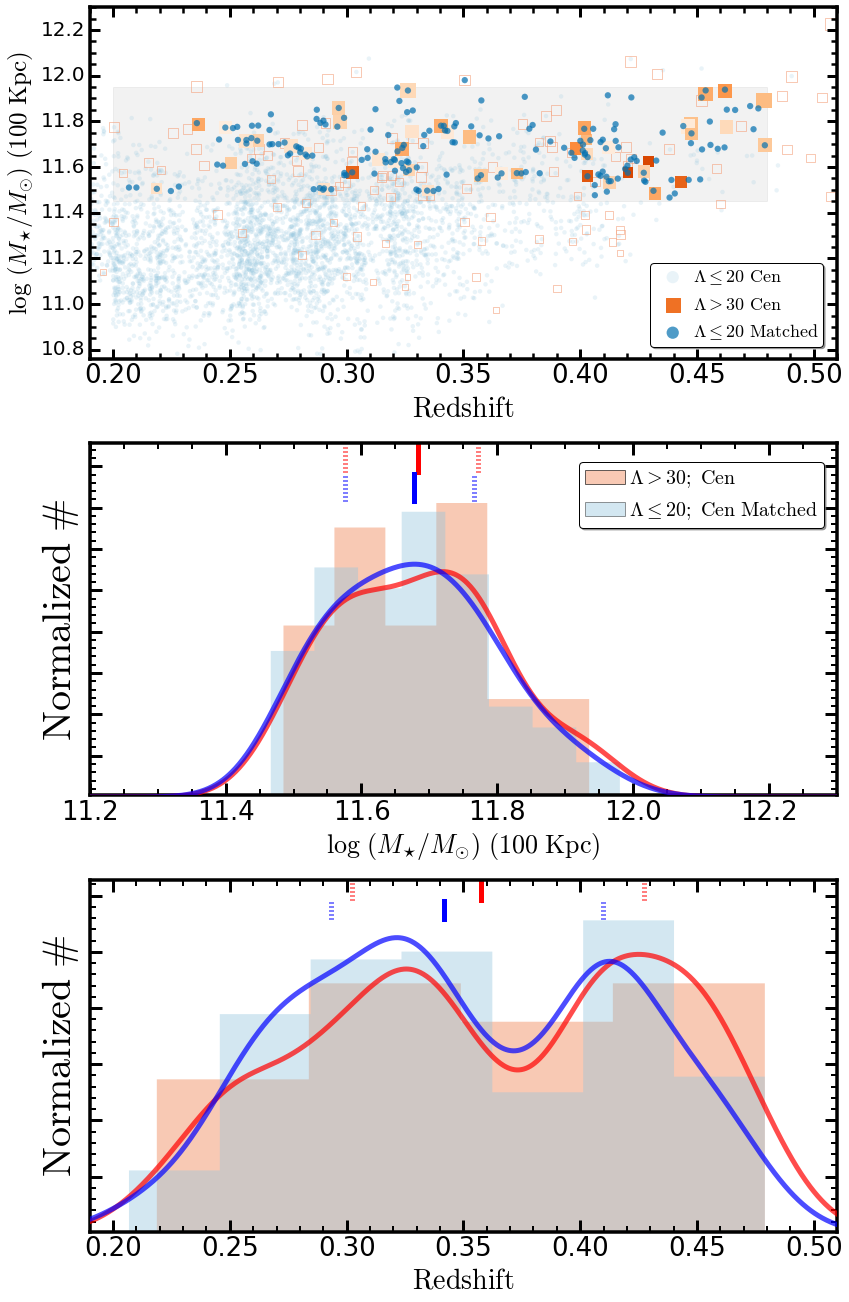

In [66]:
fig1 = plt.figure(figsize=(12, 18))
fig1.subplots_adjust(left=0.12, right=0.985, wspace=0.05,
                     bottom=0.05, top=0.995, hspace=0.24)

## Mass and Redshift limits
mmin, mmax = 11.2, 12.3
zmin, zmax = 0.19, 0.51

mx = np.linspace(mmin, mmax, 1000)
zx = np.linspace(zmin, zmax, 1000)

# ------------------------------------------------------------------------------------------------------#
# Redshift - Mass plot 
ax1 = fig1.add_subplot(311)

## Mass limits 
ax1.fill_between([zlim0, zlim1], [mlim0, mlim0], [mlim1, mlim1],
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)

## GAMA sample
p1 = ax1.scatter(gamaClean['z_use'], gamaClean['m100_c'], 
                 alpha=0.20, facecolor=BLUE0, edgecolor='none', 
                 label='$\Lambda \leq 20\ \mathrm{Cen}$')
## BCG sample
p2 = ax1.scatter(bcgClean['z_use'], bcgClean['m100_c'], 
                 facecolor='none', s=((bcgClean['m10_c'] - 10.40) * 100.0), 
                 cmap=ORG4, alpha=0.60, marker='s',
                 edgecolor=RED0, label=None)

p3 = ax1.scatter(bcgUse['z_use'], bcgUse['m100_c'], 
                 edgecolor='none', s=((bcgUse['m10_c'] - 10.40) * 200.0), 
                 cmap=ORG4, alpha=1.00, 
                 c=toColorArr(bcgUse['LAMBDA_CLUSTER'], bottom=20.0, top=70.0), 
                 label='$\Lambda > 30\ \mathrm{Cen}$', marker='s')

## Matched GAMA sample
p4 = ax1.scatter(gamaUnique['z_use'], gamaUnique['m100_c'], 
                 alpha=0.70, facecolor=BLUE1, edgecolor='none', s=40,
                 label='$\Lambda \leq 20\ \mathrm{Matched}$')

## Legend
ax1.legend(loc=(0.75, 0.035), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.1)
legend = ax1.get_legend()
legend.legendHandles[1].set_color(ORG4(0.8))
legend.legendHandles[0].set_sizes([150])
legend.legendHandles[1].set_sizes([200])
legend.legendHandles[2].set_sizes([150])

## Axes setup
### Minor Ticks on 
ax1.minorticks_on()
### Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)

##  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    
## Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

## Label
ax1.set_xlabel('$\mathrm{Redshift}$', size=28)
ax1.set_ylabel('$\log\ (M_{\star}/M_{\odot})\ (100\ \mathrm{Kpc})$', 
               size=25)

## Axis limits
ax1.set_xlim(zmin, zmax)
ax1.set_ylim(10.76, mmax)

# ------------------------------------------------------------------------------------------------------#
# Mass Plot 
ax2 = fig1.add_subplot(312)

## KDE for BCG 
bcgMKde = KernelDensity(0.06, kernel='gaussian')
bcgMKde.fit(bcgUse['m100_c'][:, None])
bcgMDens = np.exp(bcgMKde.score_samples(mx[:, None]))

## KDE for GAMA
gamaMKde = KernelDensity(0.06, kernel='gaussian')
gamaMKde.fit(gamaUnique['m100_c'][:, None])
gamaMDens = np.exp(gamaMKde.score_samples(mx[:, None]))

## Histogram 
aa, _, _ = hist(bcgUse['m100_c'], bins='knuth', ax=ax2, normed=True, zorder=1,
                histtype='stepfilled', edgecolor='none', facecolor=RED0, 
                alpha=0.6, label='$\Lambda > 30;\ \mathrm{Cen}$')
bb, _, _ = hist(gamaUnique['m100_c'], bins='knuth', ax=ax2, normed=True, zorder=1,
                histtype='stepfilled', edgecolor='none', facecolor=BLUE0, 
                alpha=0.4, label='$\Lambda \leq 20;\ \mathrm{Cen\ Matched}$')

## Density plot 
ax2.plot(mx, bcgMDens, '-', color='r', zorder=3, linewidth=5.0, alpha=0.7)
ax2.plot(mx, gamaMDens, '-', color='b', zorder=3, linewidth=5.0, alpha=0.7)

## X, Y Limits
ax2.set_xlim(mmin, mmax)
ylim = np.nanmax(np.hstack([aa, bb])) + 0.72
ax2.set_ylim(0.02, ylim)

## Legend
ax2.legend(loc=(0.655, 0.76), shadow=True, fancybox=True, 
           numpoints=1, fontsize=20, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.2)

## X, Y Lables
ax2.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (\mathrm{100\ Kpc})$', size=26)
ax2.set_ylabel('$\mathrm{Normalized\ \#}$', size=40)

## Highlight the median 
### BCG
ax2.plot([np.nanmedian(bcgUse['m100_c']), np.nanmedian(bcgUse['m100_c'])],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r')
ax2.plot([np.percentile(bcgUse['m100_c'], 25), 
          np.percentile(bcgUse['m100_c'], 25)],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r', linestyle=':')
ax2.plot([np.percentile(bcgUse['m100_c'], 75), 
          np.percentile(bcgUse['m100_c'], 75)],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r', linestyle=':')
### GAMA
ax2.plot([np.nanmedian(gamaUnique['m100_c']), np.nanmedian(gamaUnique['m100_c'])],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b')
ax2.plot([np.percentile(gamaUnique['m100_c'], 25), 
          np.percentile(gamaUnique['m100_c'], 25)],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b', linestyle=':')
ax2.plot([np.percentile(gamaUnique['m100_c'], 75), 
          np.percentile(gamaUnique['m100_c'], 75)],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b', linestyle=':')

## Ticks
ax2.minorticks_on()
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
ax2.tick_params('both', length=12, width=3, which='major')
ax2.tick_params('both', length=6, width=2, which='minor')
ax2.yaxis.set_major_formatter(NullFormatter())

## Width of the axes
ax2.spines['top'].set_linewidth(3.5)
ax2.spines['right'].set_linewidth(3.5)
ax2.spines['bottom'].set_linewidth(3.5)
ax2.spines['left'].set_linewidth(3.5)

# ------------------------------------------------------------------------------------------------------#
# Redshift Plot 
ax3 = fig1.add_subplot(313)

## KDE for BCG 
bcgMKde = KernelDensity(0.02, kernel='gaussian')
bcgMKde.fit(bcgUse['z_use'][:, None])
bcgMDens = np.exp(bcgMKde.score_samples(zx[:, None]))

## KDE for GAMA
gamaMKde = KernelDensity(0.02, kernel='gaussian')
gamaMKde.fit(gamaUnique['z_use'][:, None])
gamaMDens = np.exp(gamaMKde.score_samples(zx[:, None]))

## Histogram 
aa, _, _ = hist(bcgUse['z_use'], bins='knuth', ax=ax3, normed=True, zorder=1,
                histtype='stepfilled', edgecolor='none', facecolor=RED0, 
                alpha=0.6)
bb, _, _ = hist(gamaUnique['z_use'], bins='knuth', ax=ax3, normed=True, zorder=1,
                histtype='stepfilled', edgecolor='none', facecolor=BLUE0, 
                alpha=0.4)

## Density plot 
ax3.plot(zx, bcgMDens, '-', color='r', zorder=3, linewidth=5.0, alpha=0.7)
ax3.plot(zx, gamaMDens, '-', color='b', zorder=3, linewidth=5.0, alpha=0.7)

## X, Y Limits
ax3.set_xlim(zmin, zmax)
ylim = np.nanmax(np.hstack([aa, bb])) + 0.72
ax3.set_ylim(0.02, ylim)

## X, Y Lables
ax3.set_xlabel('$\mathrm{Redshift}$', size=28)
ax3.set_ylabel('$\mathrm{Normalized\ \#}$', size=40)

## Highlight the median 
### BCG
ax3.plot([np.nanmedian(bcgUse['z_use']), np.nanmedian(bcgUse['z_use'])],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r')
ax3.plot([np.percentile(bcgUse['z_use'], 25), 
          np.percentile(bcgUse['z_use'], 25)],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r', linestyle=':')
ax3.plot([np.percentile(bcgUse['z_use'], 75), 
          np.percentile(bcgUse['z_use'], 75)],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r', linestyle=':')
### GAMA
ax3.plot([np.nanmedian(gamaUnique['z_use']), np.nanmedian(gamaUnique['z_use'])],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b')
ax3.plot([np.percentile(gamaUnique['z_use'], 25), 
          np.percentile(gamaUnique['z_use'], 25)],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b', linestyle=':')
ax3.plot([np.percentile(gamaUnique['z_use'], 75), 
          np.percentile(gamaUnique['z_use'], 75)],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b', linestyle=':')

## Ticks
ax3.minorticks_on()
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
ax3.tick_params('both', length=12, width=3, which='major')
ax3.tick_params('both', length=6, width=2, which='minor')
ax3.yaxis.set_major_formatter(NullFormatter())

## Width of the axes
ax3.spines['top'].set_linewidth(3.5)
ax3.spines['right'].set_linewidth(3.5)
ax3.spines['bottom'].set_linewidth(3.5)
ax3.spines['left'].set_linewidth(3.5)

# ------------------------------------------------------------------------------------------------------#

plt.show()

fig1.savefig('../figure/hscMassive_matchAll_m100_1a.png', dpi=230)

In [67]:
# Organize the sample
prof_bcg_ma = getStackProfiles(bcgUse, bcgDir, name='test_bcg_matchTot_m100_1')

prof_gama_ma = getStackProfiles(gamaUnique, gamaDir, name='test_gamaTot_m100_1')

# Median profiles
bm_sm, bm_mm, bm_amg, bm_stdm = organizeSbp(prof_bcg_ma, col1='muI1', 
                                                col2='LOGM2LI_C', kind='mass')
gu_sm, gu_mm, gu_amg, gu_stdm = organizeSbp(prof_gama_ma, col1='muI1', 
                                                col2='LOGM2LI_C', kind='mass')
# Larger mask
bm_sm_b, bm_mm_b, bm_amg_b, bm_stdm_b = organizeSbp(prof_bcg_ma, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass')
gu_sm_b, gu_mm_b, gu_amg_b, gu_stdm_b = organizeSbp(prof_gama_ma, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass')
# Random mix sample 
mixM_sm = np.vstack([gu_sm, bm_sm])
randM_sm = []
ii = 0
while ii < 8000:
    mprof = np.nanmedian(mixM_sm[np.random.choice(len(mixM_sm), len(bm_sm), 
                                                   replace=False)], axis=0)
    randM_sm.append(mprof)
    ii += 1 
    
# Integration
indInt = np.where((RSMA_COMMON ** 4.0) <= 101.01)

isoArea = (np.pi * ((RSMA_COMMON[indInt] ** 4.0) ** 2.0) * 0.95)
isoRing = np.append(isoArea[0], [isoArea[1:] - isoArea[:-1]])
print(np.log10(np.nansum(10.0 ** bm_mm[2][indInt] * isoRing)))
print(np.log10(np.nansum(10.0 ** gu_mm[2][indInt] * isoRing)))

## Sample test_bcg_matchTot_m100_1 : Will deal with 45 galaxies

## Save test_bcg_matchTot_m100_1 to /Users/songhuang/work/hscs/gama_massive/sbp/redbcg/test_bcg_matchTot_m100_1_profs.pkl
## Sample test_gamaTot_m100_1 : Will deal with 185 galaxies

## Save test_gamaTot_m100_1 to /Users/songhuang/work/hscs/gama_massive/sbp/gama/test_gamaTot_m100_1_profs.pkl
11.376279737
11.3660674305


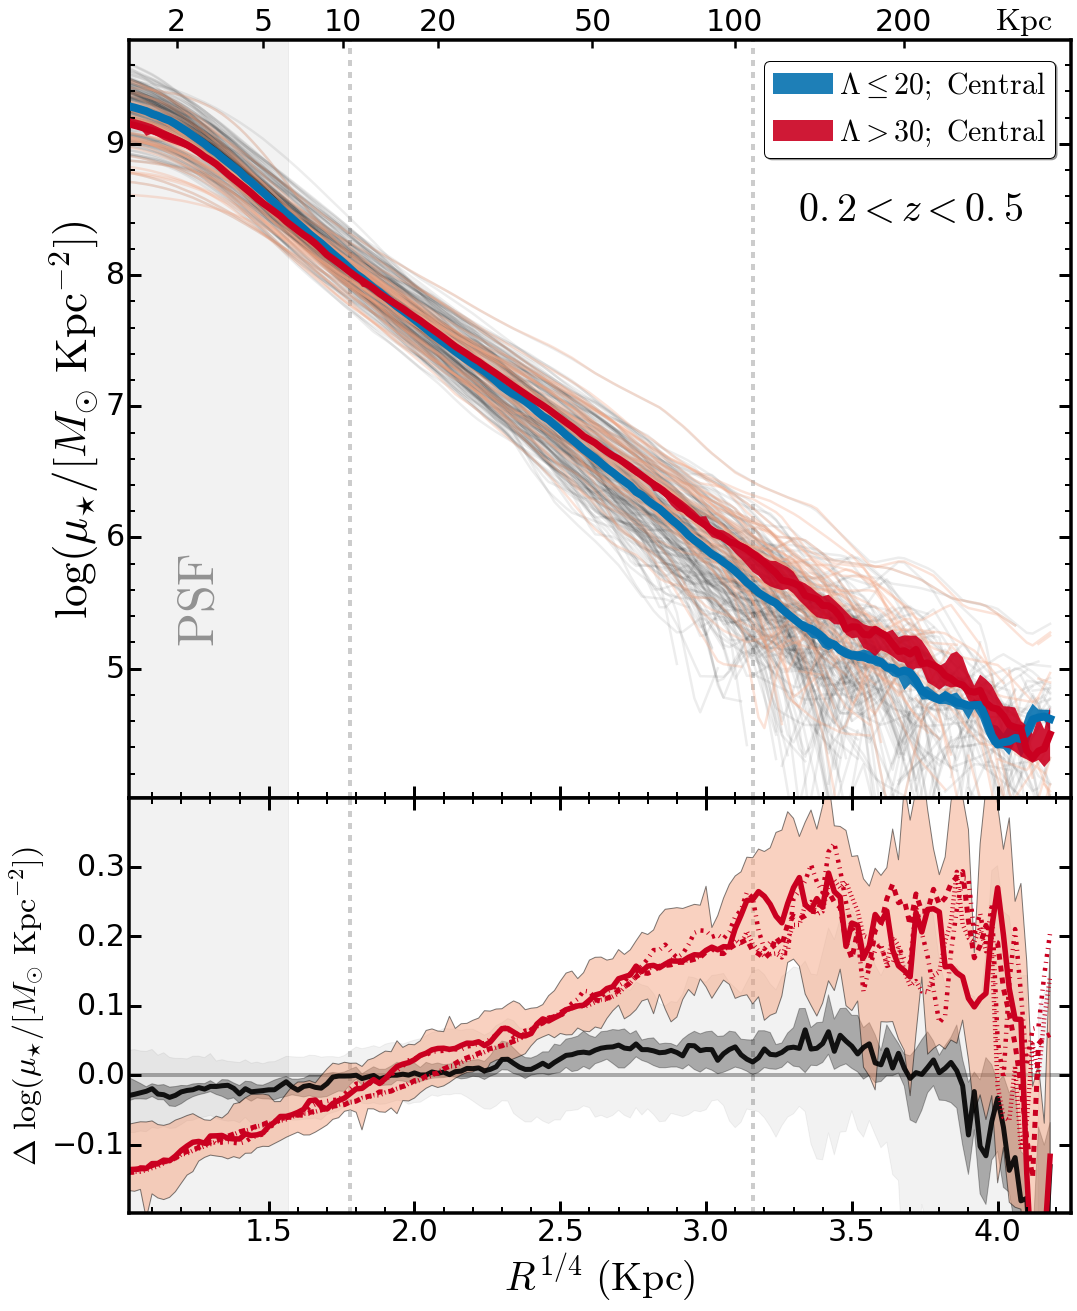

In [71]:
# --------------------------------------------------------------------------------------- #
## Setup up figure
fig2 = plt.figure(figsize=(15, 18))

ax1 = plt.axes(SBP2)
ax3 = plt.axes(SBP1)

########################################################################################
## Region affected by PSF
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [2.0, 2.0], [11.0, 11.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
## Mark the two interesting radius
# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

########################################################################################
## Individual profiles
for gg in gu_sm:
    ax1.plot(RSMA_COMMON, gg, c='k', alpha=0.07, linewidth=2.5)
for bb in bm_sm:
    ax1.plot(RSMA_COMMON, bb, c=RED0, alpha=0.30, linewidth=2.5)

## Median profiles
ax1.fill_between(RSMA_COMMON, gu_mm[0], gu_mm[1], 
                 facecolor=BLUE1, edgecolor='none', alpha=0.9, 
                 zorder=1005, label="$\Lambda \leq 20;\ \mathrm{Central}$")
ax1.fill_between(RSMA_COMMON, bm_mm[0], bm_mm[1], 
                 facecolor=RED1, edgecolor='none', alpha=0.9, 
                 zorder=1005, label="$\Lambda > 30;\ \mathrm{Central}$")

ax1.plot(RSMA_COMMON, gu_mm[2], linestyle='-', linewidth=8.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
ax1.plot(RSMA_COMMON, bm_mm[2], linestyle='-', linewidth=7.0, 
         c=RED1, alpha=1.0, zorder=1010)

## X, Y Lables
ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=45)

## Ticks
ax1.minorticks_on()
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax1.tick_params('both', length=12, width=3, which='major')
ax1.tick_params('both', length=6, width=2, which='minor')

## Remove the X-axis label
ax1.xaxis.set_major_formatter(NullFormatter())

## Width of the axes
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

## Label the PSF region 
ax1.text(0.05, 0.20, '$\mathrm{PSF}$', rotation='vertical',
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=50.0, transform=ax1.transAxes, weight='bold', 
         color='k', alpha=0.4)

## Legend
ax1.legend(loc=(0.675, 0.845), shadow=True, fancybox=True, 
           numpoints=1, fontsize=30, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.2)

## Label the PSF region 
ax1.text(0.83, 0.75, '$0.2 < z < 0.5$', 
         verticalalignment='bottom', horizontalalignment='center',
         fontsize=40.0, transform=ax1.transAxes, weight='bold', 
         color='k')

## X, Y limits
ax1.set_xlim(1.02, 4.25)
ax1.set_ylim(4.01, 9.79)

########################################################################################
## Secondary Axis 
ax2 = ax1.twiny()
kpcs = np.asarray([2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0])
kpcTicks= (kpcs ** 0.25)
ax2.set_xlim(1.02, 4.35)
ax2.set_ylim(4.01, 9.79)
ax2.set_xticks(kpcTicks)
ax2.set_xticklabels(['{:g}'.format(kpc) for kpc in kpcs], fontsize=30)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax2.text(0.92, 1.0035, '$\mathrm{Kpc}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=32.0, transform=ax2.transAxes)

########################################################################################

## Highlight zero 
ax3.axhline(0.0, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.3)

### 10 Kpc 
ax3.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
### 100 Kpc
ax3.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

### z = 0.4 : 1"=5.4 Kpc
ax3.fill_between([0.0, 6.0**0.25], [-2.0, -2.0], [2.0, 2.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)

## Random Mixed Sample
ax3.fill_between(RSMA_COMMON, 
                 np.percentile(randM_sm - gu_mm[2], 3, axis=0), 
                 np.percentile(randM_sm - gu_mm[2], 97, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax3.fill_between(RSMA_COMMON, 
                 np.percentile(randM_sm - gu_mm[2], 31, axis=0), 
                 np.percentile(randM_sm - gu_mm[2], 69, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.30, zorder=0)

ax3.plot(RSMA_COMMON, np.percentile(randM_sm - gu_mm[2], 50, axis=0), 
         c='k', linewidth=5.0, linestyle='-', alpha=0.9)

## BCG-GAMA
ax3.fill_between(RSMA_COMMON, 
                 (bm_mm[0] - gu_mm[1]), (bm_mm[1] - gu_mm[0]),
                 facecolor=RED0, edgecolor='k', alpha=0.50, zorder=1)

ax3.plot(RSMA_COMMON, bm_mm[2] - gu_mm[2], c=RED1, linewidth=5.5, 
         linestyle='-')
ax3.plot(RSMA_COMMON, bm_amg[2] - gu_amg[2], c=RED1, linewidth=5.0, 
         linestyle='--')

ax3.plot(RSMA_COMMON, bm_mm_b[2] - gu_mm_b[2], c=RED1, linewidth=4.5, 
         linestyle='-.')
ax3.plot(RSMA_COMMON, bm_amg_b[2] - gu_amg_b[2], c=RED1, linewidth=4.5, 
         linestyle=':')

ax3.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax3.set_ylabel('$\Delta\ \log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=32)

## X, Y Limits
ax3.set_xlim(1.02, 4.25)
ax3.set_ylim(-0.199, 0.399)

## Axes setup
### Minor Ticks on 
ax3.minorticks_on()
ax3.tick_params(axis='y', which='minor', left='off', right='off')

for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax3.tick_params('both', length=12, width=3, which='major')
ax3.tick_params('both', length=6, width=2, which='minor')

ax3.spines['top'].set_linewidth(3.5)
ax3.spines['right'].set_linewidth(3.5)
ax3.spines['bottom'].set_linewidth(3.5)
ax3.spines['left'].set_linewidth(3.5)

########################################################################################
plt.show()

fig2.savefig('../figure/hscMassive_matchAll_m100_1b.png', dpi=230)

## Using Mass Model C:  0.18 < z < 0.42;  Lambda > 20

In [72]:
# Sample Matching Using K-Dtree

## Mass and Redshift Limit 
mlim0, mlim1 = 11.45, 11.95
zlim0, zlim1 = 0.18, 0.42
lamLimit = 22
pcenLimit = 0.8

## BCG sample used for matching
bcgUse = bcgClean[(bcgClean['m100_c'] >= mlim0) & 
                  (bcgClean['m100_c'] <= mlim1) & 
                  (bcgClean['z_use'] >= zlim0) &
                  (bcgClean['z_use'] <= zlim1) &
                  (bcgClean['LAMBDA_CLUSTER'] >= lamLimit) &
                  (bcgClean['P_CEN_1'] >= pcenLimit)]
print("# BCG Sample Size: ", len(bcgUse))

## GAMA sample used for matching
gamaUse = gamaClean[(gamaClean['m100_c'] >= (mlim0 + 0.005)) & 
                    (gamaClean['m100_c'] <= (mlim1 + 0.05)) & 
                    (gamaClean['z_use'] >= (zlim0 - 0.01)) &
                    (gamaClean['z_use'] <= (zlim1 + 0.01))]
print("# GAMA Sample Size: ", len(gamaUse))

## Isolate the parameters used for matching 
bcgZM1 = np.stack((np.asarray(bcgUse[bcgUse['m100_c'] <= 11.65]['m100_c']), 
                   np.asarray(bcgUse[bcgUse['m100_c'] <= 11.65]['z_use'])), axis=-1)
bcgZM2 = np.stack((np.asarray(bcgUse[bcgUse['m100_c'] > 11.65]['m100_c']), 
                   np.asarray(bcgUse[bcgUse['m100_c'] > 11.65]['z_use'])), axis=-1)

gamaZM = np.stack((np.asarray(gamaUse['m100_c']), 
                   np.asarray(gamaUse['z_use'])), axis=-1)

## Build the Tree
gamaTree = KDTree(gamaZM, leaf_size=4)  

dist, ind1 = gamaTree.query(bcgZM1, k=4) 
print("# Matched < 11.65", len(ind1.ravel()))
dist, ind2 = gamaTree.query(bcgZM2, k=6) 
print("# Matched > 11.65", len(ind2.ravel()))

indAll = np.hstack([ind1.ravel(), ind2.ravel()])
indUni = np.unique(indAll)
print("# All and Unique Matched Sample", len(indAll), len(indUni))

gamaMatch = gamaUse[indAll]
gamaUnique = gamaUse[indUni]

# BCG Sample Size:  63
# GAMA Sample Size:  920
# Matched < 11.65 116
# Matched > 11.65 204
# All and Unique Matched Sample 320 251


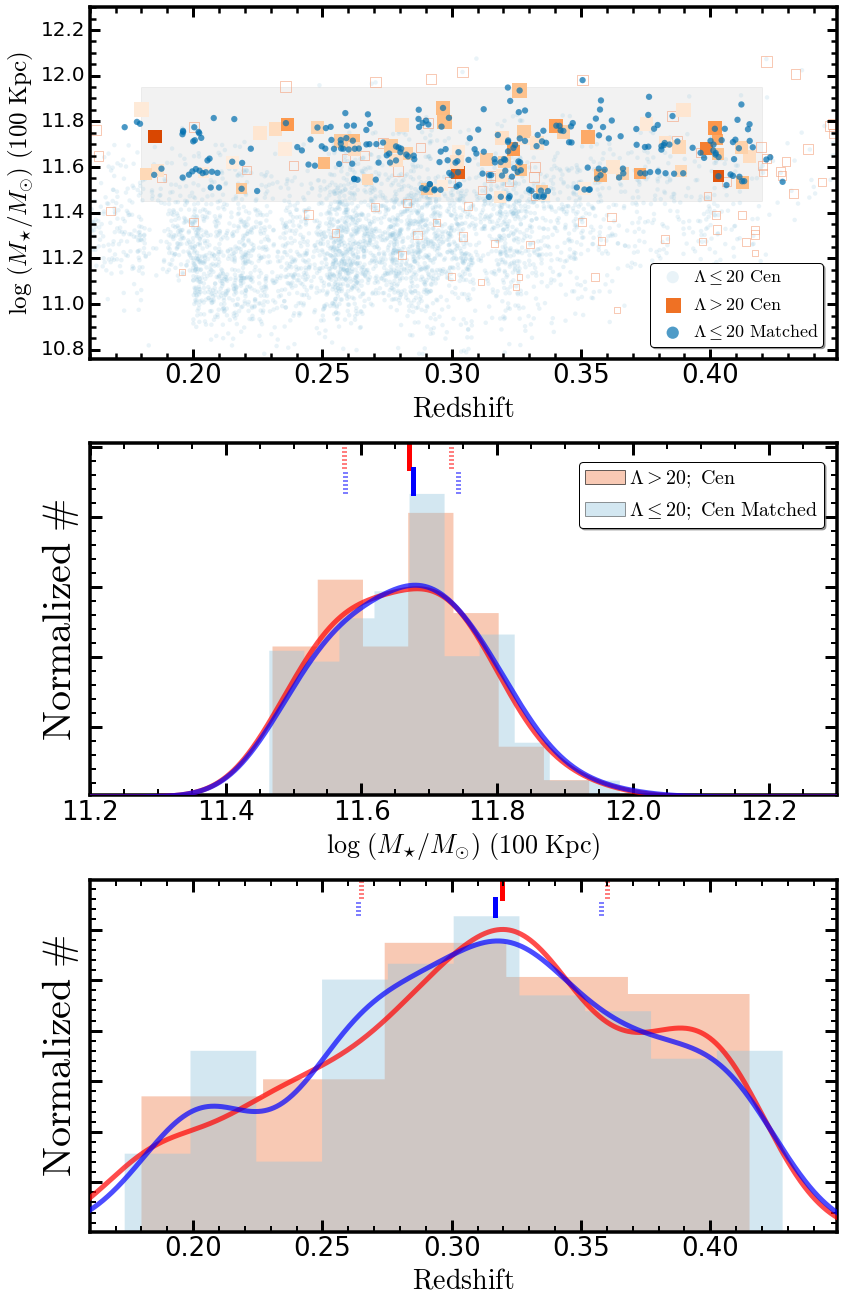

In [73]:
fig1 = plt.figure(figsize=(12, 18))
fig1.subplots_adjust(left=0.12, right=0.985, wspace=0.05,
                     bottom=0.05, top=0.995, hspace=0.24)

## Mass and Redshift limits
mmin, mmax = 11.2, 12.3
zmin, zmax = 0.16, 0.449

mx = np.linspace(mmin, mmax, 1000)
zx = np.linspace(zmin, zmax, 1000)

# ------------------------------------------------------------------------------------------------------#
# Redshift - Mass plot 
ax1 = fig1.add_subplot(311)

## Mass limits 
ax1.fill_between([zlim0, zlim1], [mlim0, mlim0], [mlim1, mlim1],
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)

## GAMA sample
p1 = ax1.scatter(gamaClean['z_use'], gamaClean['m100_c'], 
                 alpha=0.20, facecolor=BLUE0, edgecolor='none', 
                 label='$\Lambda \leq 20\ \mathrm{Cen}$')
## BCG sample
p2 = ax1.scatter(bcgClean['z_use'], bcgClean['m100_c'], 
                 facecolor='none', s=((bcgClean['m10_c'] - 10.40) * 100.0), 
                 cmap=ORG4, alpha=0.60, marker='s',
                 edgecolor=RED0, label=None)

p3 = ax1.scatter(bcgUse['z_use'], bcgUse['m100_c'], 
                 edgecolor='none', s=((bcgUse['m10_c'] - 10.40) * 200.0), 
                 cmap=ORG4, alpha=1.00, 
                 c=toColorArr(bcgUse['LAMBDA_CLUSTER'], bottom=20.0, top=70.0), 
                 label='$\Lambda > 20\ \mathrm{Cen}$', marker='s')

## Matched GAMA sample
p4 = ax1.scatter(gamaUnique['z_use'], gamaUnique['m100_c'], 
                 alpha=0.70, facecolor=BLUE1, edgecolor='none', s=40,
                 label='$\Lambda \leq 20\ \mathrm{Matched}$')

## Legend
ax1.legend(loc=(0.75, 0.035), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.1)
legend = ax1.get_legend()
legend.legendHandles[1].set_color(ORG4(0.8))
legend.legendHandles[0].set_sizes([150])
legend.legendHandles[1].set_sizes([200])
legend.legendHandles[2].set_sizes([150])

## Axes setup
### Minor Ticks on 
ax1.minorticks_on()
### Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)

##  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    
## Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

## Label
ax1.set_xlabel('$\mathrm{Redshift}$', size=28)
ax1.set_ylabel('$\log\ (M_{\star}/M_{\odot})\ (100\ \mathrm{Kpc})$', 
               size=25)

## Axis limits
ax1.set_xlim(zmin, zmax)
ax1.set_ylim(10.76, mmax)

# ------------------------------------------------------------------------------------------------------#
# Mass Plot 
ax2 = fig1.add_subplot(312)

## KDE for BCG 
bcgMKde = KernelDensity(0.06, kernel='gaussian')
bcgMKde.fit(bcgUse['m100_c'][:, None])
bcgMDens = np.exp(bcgMKde.score_samples(mx[:, None]))

## KDE for GAMA
gamaMKde = KernelDensity(0.06, kernel='gaussian')
gamaMKde.fit(gamaUnique['m100_c'][:, None])
gamaMDens = np.exp(gamaMKde.score_samples(mx[:, None]))

## Histogram 
aa, _, _ = hist(bcgUse['m100_c'], bins='knuth', ax=ax2, normed=True, zorder=1,
                histtype='stepfilled', edgecolor='none', facecolor=RED0, 
                alpha=0.6, label='$\Lambda > 20;\ \mathrm{Cen}$')
bb, _, _ = hist(gamaUnique['m100_c'], bins='knuth', ax=ax2, normed=True, zorder=1,
                histtype='stepfilled', edgecolor='none', facecolor=BLUE0, 
                alpha=0.4, label='$\Lambda \leq 20;\ \mathrm{Cen\ Matched}$')

## Density plot 
ax2.plot(mx, bcgMDens, '-', color='r', zorder=3, linewidth=5.0, alpha=0.7)
ax2.plot(mx, gamaMDens, '-', color='b', zorder=3, linewidth=5.0, alpha=0.7)

## X, Y Limits
ax2.set_xlim(mmin, mmax)
ylim = np.nanmax(np.hstack([aa, bb])) + 0.72
ax2.set_ylim(0.02, ylim)

## Legend
ax2.legend(loc=(0.655, 0.76), shadow=True, fancybox=True, 
           numpoints=1, fontsize=20, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.2)

## X, Y Lables
ax2.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (\mathrm{100\ Kpc})$', size=26)
ax2.set_ylabel('$\mathrm{Normalized\ \#}$', size=40)

## Highlight the median 
### BCG
ax2.plot([np.nanmedian(bcgUse['m100_c']), np.nanmedian(bcgUse['m100_c'])],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r')
ax2.plot([np.percentile(bcgUse['m100_c'], 25), 
          np.percentile(bcgUse['m100_c'], 25)],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r', linestyle=':')
ax2.plot([np.percentile(bcgUse['m100_c'], 75), 
          np.percentile(bcgUse['m100_c'], 75)],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r', linestyle=':')
### GAMA
ax2.plot([np.nanmedian(gamaUnique['m100_c']), np.nanmedian(gamaUnique['m100_c'])],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b')
ax2.plot([np.percentile(gamaUnique['m100_c'], 25), 
          np.percentile(gamaUnique['m100_c'], 25)],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b', linestyle=':')
ax2.plot([np.percentile(gamaUnique['m100_c'], 75), 
          np.percentile(gamaUnique['m100_c'], 75)],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b', linestyle=':')

## Ticks
ax2.minorticks_on()
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
ax2.tick_params('both', length=12, width=3, which='major')
ax2.tick_params('both', length=6, width=2, which='minor')
ax2.yaxis.set_major_formatter(NullFormatter())

## Width of the axes
ax2.spines['top'].set_linewidth(3.5)
ax2.spines['right'].set_linewidth(3.5)
ax2.spines['bottom'].set_linewidth(3.5)
ax2.spines['left'].set_linewidth(3.5)

# ------------------------------------------------------------------------------------------------------#
# Redshift Plot 
ax3 = fig1.add_subplot(313)

## KDE for BCG 
bcgMKde = KernelDensity(0.02, kernel='gaussian')
bcgMKde.fit(bcgUse['z_use'][:, None])
bcgMDens = np.exp(bcgMKde.score_samples(zx[:, None]))

## KDE for GAMA
gamaMKde = KernelDensity(0.02, kernel='gaussian')
gamaMKde.fit(gamaUnique['z_use'][:, None])
gamaMDens = np.exp(gamaMKde.score_samples(zx[:, None]))

## Histogram 
aa, _, _ = hist(bcgUse['z_use'], bins='knuth', ax=ax3, normed=True, zorder=1,
                histtype='stepfilled', edgecolor='none', facecolor=RED0, 
                alpha=0.6)
bb, _, _ = hist(gamaUnique['z_use'], bins='knuth', ax=ax3, normed=True, zorder=1,
                histtype='stepfilled', edgecolor='none', facecolor=BLUE0, 
                alpha=0.4)

## Density plot 
ax3.plot(zx, bcgMDens, '-', color='r', zorder=3, linewidth=5.0, alpha=0.7)
ax3.plot(zx, gamaMDens, '-', color='b', zorder=3, linewidth=5.0, alpha=0.7)

## X, Y Limits
ax3.set_xlim(zmin, zmax)
ylim = np.nanmax(np.hstack([aa, bb])) + 0.72
ax3.set_ylim(0.02, ylim)

## X, Y Lables
ax3.set_xlabel('$\mathrm{Redshift}$', size=28)
ax3.set_ylabel('$\mathrm{Normalized\ \#}$', size=40)

## Highlight the median 
### BCG
ax3.plot([np.nanmedian(bcgUse['z_use']), np.nanmedian(bcgUse['z_use'])],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r')
ax3.plot([np.percentile(bcgUse['z_use'], 25), 
          np.percentile(bcgUse['z_use'], 25)],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r', linestyle=':')
ax3.plot([np.percentile(bcgUse['z_use'], 75), 
          np.percentile(bcgUse['z_use'], 75)],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r', linestyle=':')
### GAMA
ax3.plot([np.nanmedian(gamaUnique['z_use']), np.nanmedian(gamaUnique['z_use'])],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b')
ax3.plot([np.percentile(gamaUnique['z_use'], 25), 
          np.percentile(gamaUnique['z_use'], 25)],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b', linestyle=':')
ax3.plot([np.percentile(gamaUnique['z_use'], 75), 
          np.percentile(gamaUnique['z_use'], 75)],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b', linestyle=':')

## Ticks
ax3.minorticks_on()
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
ax3.tick_params('both', length=12, width=3, which='major')
ax3.tick_params('both', length=6, width=2, which='minor')
ax3.yaxis.set_major_formatter(NullFormatter())

## Width of the axes
ax3.spines['top'].set_linewidth(3.5)
ax3.spines['right'].set_linewidth(3.5)
ax3.spines['bottom'].set_linewidth(3.5)
ax3.spines['left'].set_linewidth(3.5)

# ------------------------------------------------------------------------------------------------------#

plt.show()

fig1.savefig('../figure/hscMassive_matchAll_m100_2a.png', dpi=230)

In [74]:
# Organize the sample
prof_bcg_ma = getStackProfiles(bcgUse, bcgDir, name='test_bcg_matchTot_m100_2')

prof_gama_ma = getStackProfiles(gamaUnique, gamaDir, name='test_gamaTot_m100_2')

# Median profiles
bm_sm, bm_mm, bm_amg, bm_stdm = organizeSbp(prof_bcg_ma, col1='muI1', 
                                            col2='LOGM2LI_C', kind='mass')
gu_sm, gu_mm, gu_amg, gu_stdm = organizeSbp(prof_gama_ma, col1='muI1', 
                                            col2='LOGM2LI_C', kind='mass')
# Larger mask
bm_sm_b, bm_mm_b, bm_amg_b, bm_stdm_b = organizeSbp(prof_bcg_ma, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass')
gu_sm_b, gu_mm_b, gu_amg_b, gu_stdm_b = organizeSbp(prof_gama_ma, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass')
# Random mix sample 
mixM_sm = np.vstack([gu_sm, bm_sm])
randM_sm = []
ii = 0
while ii < 8000:
    mprof = np.nanmedian(mixM_sm[np.random.choice(len(mixM_sm), len(bm_sm), 
                                                   replace=False)], axis=0)
    randM_sm.append(mprof)
    ii += 1 
    
# Integration
indInt = np.where((RSMA_COMMON ** 4.0) <= 101.01)

isoArea = (np.pi * ((RSMA_COMMON[indInt] ** 4.0) ** 2.0) * 0.95)
isoRing = np.append(isoArea[0], [isoArea[1:] - isoArea[:-1]])
print(np.log10(np.nansum(10.0 ** bm_mm[2][indInt] * isoRing)))
print(np.log10(np.nansum(10.0 ** gu_mm[2][indInt] * isoRing)))

## Sample test_bcg_matchTot_m100_2 : Will deal with 63 galaxies

## Save test_bcg_matchTot_m100_2 to /Users/songhuang/work/hscs/gama_massive/sbp/redbcg/test_bcg_matchTot_m100_2_profs.pkl
## Sample test_gamaTot_m100_2 : Will deal with 251 galaxies

## Save test_gamaTot_m100_2 to /Users/songhuang/work/hscs/gama_massive/sbp/gama/test_gamaTot_m100_2_profs.pkl
11.3863688578
11.3900253235


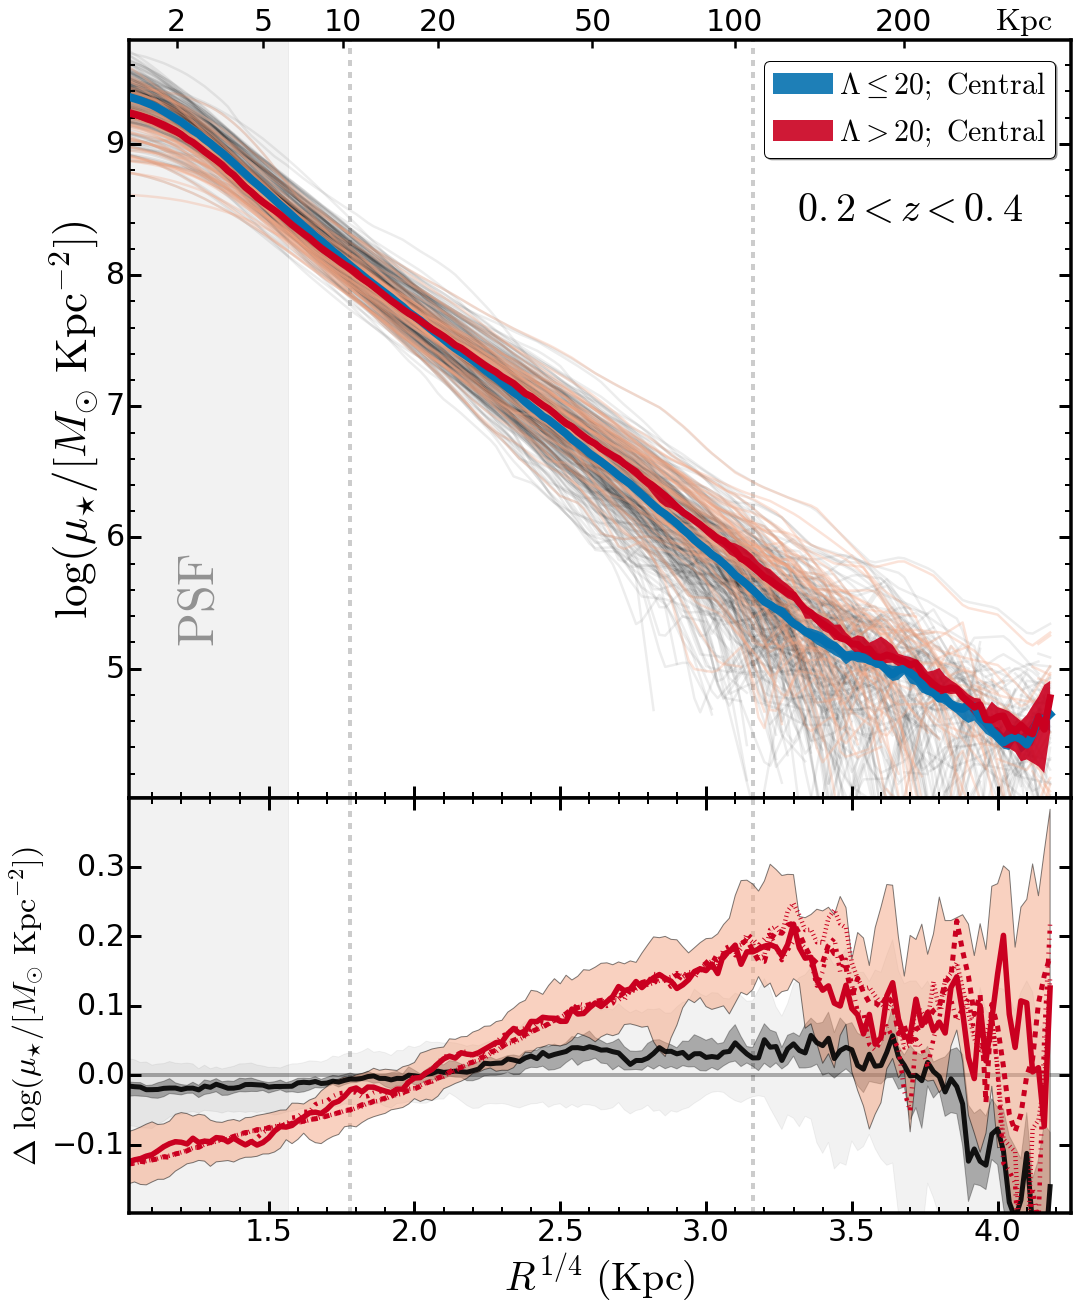

In [75]:
# --------------------------------------------------------------------------------------- #
## Setup up figure
fig2 = plt.figure(figsize=(15, 18))

ax1 = plt.axes(SBP2)
ax3 = plt.axes(SBP1)

########################################################################################
## Region affected by PSF
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [2.0, 2.0], [11.0, 11.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
## Mark the two interesting radius
# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

########################################################################################
## Individual profiles
for gg in gu_sm:
    ax1.plot(RSMA_COMMON, gg, c='k', alpha=0.07, linewidth=2.5)
for bb in bm_sm:
    ax1.plot(RSMA_COMMON, bb, c=RED0, alpha=0.30, linewidth=2.5)

## Median profiles
ax1.fill_between(RSMA_COMMON, gu_mm[0], gu_mm[1], 
                 facecolor=BLUE1, edgecolor='none', alpha=0.9, 
                 zorder=1005, label="$\Lambda \leq 20;\ \mathrm{Central}$")
ax1.fill_between(RSMA_COMMON, bm_mm[0], bm_mm[1], 
                 facecolor=RED1, edgecolor='none', alpha=0.9, 
                 zorder=1005, label="$\Lambda > 20;\ \mathrm{Central}$")

ax1.plot(RSMA_COMMON, gu_mm[2], linestyle='-', linewidth=8.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
ax1.plot(RSMA_COMMON, bm_mm[2], linestyle='-', linewidth=7.0, 
         c=RED1, alpha=1.0, zorder=1010)

## X, Y Lables
ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=45)

## Ticks
ax1.minorticks_on()
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax1.tick_params('both', length=12, width=3, which='major')
ax1.tick_params('both', length=6, width=2, which='minor')

## Remove the X-axis label
ax1.xaxis.set_major_formatter(NullFormatter())

## Width of the axes
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

## Label the PSF region 
ax1.text(0.05, 0.20, '$\mathrm{PSF}$', rotation='vertical',
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=50.0, transform=ax1.transAxes, weight='bold', 
         color='k', alpha=0.4)

## Legend
ax1.legend(loc=(0.675, 0.845), shadow=True, fancybox=True, 
           numpoints=1, fontsize=30, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.2)

## Label the PSF region 
ax1.text(0.83, 0.75, '$0.2 < z < 0.4$', 
         verticalalignment='bottom', horizontalalignment='center',
         fontsize=40.0, transform=ax1.transAxes, weight='bold', 
         color='k')

## X, Y limits
ax1.set_xlim(1.02, 4.25)
ax1.set_ylim(4.01, 9.79)

########################################################################################
## Secondary Axis 
ax2 = ax1.twiny()
kpcs = np.asarray([2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0])
kpcTicks= (kpcs ** 0.25)
ax2.set_xlim(1.02, 4.35)
ax2.set_ylim(4.01, 9.79)
ax2.set_xticks(kpcTicks)
ax2.set_xticklabels(['{:g}'.format(kpc) for kpc in kpcs], fontsize=30)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax2.text(0.92, 1.0035, '$\mathrm{Kpc}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=32.0, transform=ax2.transAxes)

########################################################################################

## Highlight zero 
ax3.axhline(0.0, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.3)

### 10 Kpc 
ax3.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
### 100 Kpc
ax3.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

### z = 0.4 : 1"=5.4 Kpc
ax3.fill_between([0.0, 6.0**0.25], [-2.0, -2.0], [2.0, 2.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)

## Random Mixed Sample
ax3.fill_between(RSMA_COMMON, 
                 np.percentile(randM_sm - gu_mm[2], 3, axis=0), 
                 np.percentile(randM_sm - gu_mm[2], 97, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax3.fill_between(RSMA_COMMON, 
                 np.percentile(randM_sm - gu_mm[2], 31, axis=0), 
                 np.percentile(randM_sm - gu_mm[2], 69, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.30, zorder=0)

ax3.plot(RSMA_COMMON, np.percentile(randM_sm - gu_mm[2], 50, axis=0), 
         c='k', linewidth=5.0, linestyle='-', alpha=0.9)

## BCG-GAMA
ax3.fill_between(RSMA_COMMON, 
                 (bm_mm[0] - gu_mm[1]), (bm_mm[1] - gu_mm[0]),
                 facecolor=RED0, edgecolor='k', alpha=0.50, zorder=1)

ax3.plot(RSMA_COMMON, bm_mm[2] - gu_mm[2], c=RED1, linewidth=5.5, 
         linestyle='-')
ax3.plot(RSMA_COMMON, bm_amg[2] - gu_amg[2], c=RED1, linewidth=5.0, 
         linestyle='--')

ax3.plot(RSMA_COMMON, bm_mm_b[2] - gu_mm_b[2], c=RED1, linewidth=4.5, 
         linestyle='-.')
ax3.plot(RSMA_COMMON, bm_amg_b[2] - gu_amg_b[2], c=RED1, linewidth=4.5, 
         linestyle=':')

ax3.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax3.set_ylabel('$\Delta\ \log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=32)

## X, Y Limits
ax3.set_xlim(1.02, 4.25)
ax3.set_ylim(-0.199, 0.399)

## Axes setup
### Minor Ticks on 
ax3.minorticks_on()
ax3.tick_params(axis='y', which='minor', left='off', right='off')

for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax3.tick_params('both', length=12, width=3, which='major')
ax3.tick_params('both', length=6, width=2, which='minor')

ax3.spines['top'].set_linewidth(3.5)
ax3.spines['right'].set_linewidth(3.5)
ax3.spines['bottom'].set_linewidth(3.5)
ax3.spines['left'].set_linewidth(3.5)

########################################################################################
plt.show()

fig2.savefig('../figure/hscMassive_matchAll_m100_2b.png', dpi=230)

In [124]:
#### M1, no-normalization 
indEllip = np.intersect1d(np.where(RSMA_COMMON >= 0.9)[0], 
                          np.where(RSMA_COMMON <= 4.0)[0])

# GAMA M1a 
gm_se, gm_me, gm_ae, gm_de = organizeSbp(prof_gama_ma, col1='ell', col2=None, 
                                         kind='sbp', index=indEllip)
# BCG M1a 
bm_se, bm_me, bm_ae, bm_de = organizeSbp(prof_bcg_ma, col1='ell', col2=None, 
                                         kind='sbp', index=indEllip)

## NO KCORRECTION APPLIED !!
## NO KCORRECTION APPLIED !!


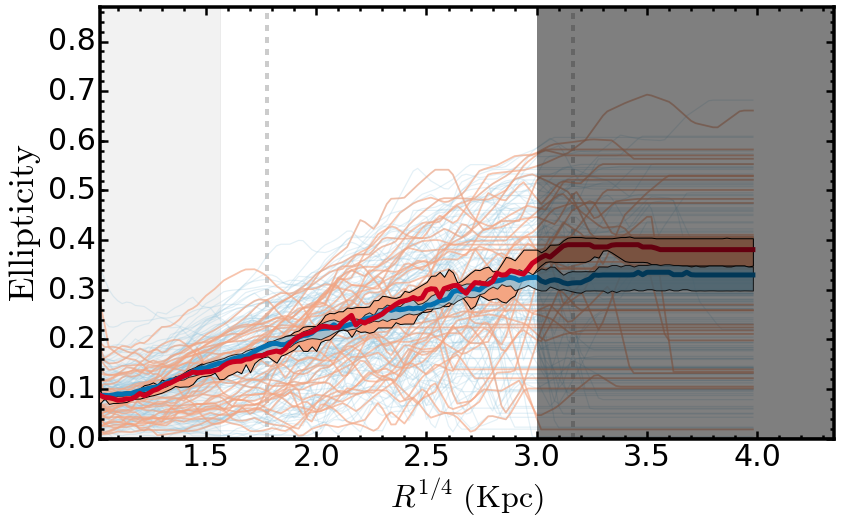

In [131]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

ax1.axhline(0.0, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.3)

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.2 : 1"=3.3 Kpc
#ax1.axvline(3.3 ** 0.25, linewidth=4.0, c='b', linestyle='--', alpha=0.2, zorder=0)
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [-2.0, -2.0], [2.0, 2.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax1.fill_between([3.0, 4.5], [-0.1, -0.1], [1.1, 1.1], 
                 facecolor='k', edgecolor='none', alpha=0.5, zorder=2000)

for i, gg in enumerate(gm_se):
    if np.nanmax(gg[RSMA_COMMON[indEllip] <= 2.1]) <= 0.4:
        ax1.plot(RSMA_COMMON[indEllip], gg, c=BLUE0, alpha=0.25, linewidth=1.2)
    else:
        np.delete(gm_se, i)
        
for j, bb in enumerate(bm_se):
    if np.nanmax(bb[RSMA_COMMON[indEllip] <= 2.1]) <= 0.4:
        ax1.plot(RSMA_COMMON[indEllip], bb, c=RED0, alpha=0.65, linewidth=1.8)
    else:
        np.delete(bm_se, j)
        
ax1.fill_between(RSMA_COMMON[indEllip], bm_me[0], bm_me[1], 
                 facecolor=RED0, edgecolor='k', alpha=1.0, zorder=1005)
ax1.fill_between(RSMA_COMMON[indEllip], gm_me[0], gm_me[1], 
                 facecolor=BLUE0, edgecolor='k', alpha=0.8, zorder=1005)

ax1.plot(RSMA_COMMON[indEllip], gm_me[2], linestyle='-', linewidth=5.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
ax1.plot(RSMA_COMMON[indEllip], bm_me[2], linestyle='-', linewidth=5.0, 
         c=RED1, alpha=1.0, zorder=1010)



ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=32)
ax1.set_ylabel('$\mathrm{Ellipticity}$', size=36)

ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(-0.0, 0.87)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#ax1.text(0.15, 0.88, '$11.5 < \log (M_{\star}) < 11.7$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=30.0, transform=ax1.transAxes)

plt.show()

#fig.savefig('../figure/hscMassive_eprof_m1_test.png', dpi=230)

In [127]:
# GAMA M1a 
gm_sgi, gm_mgi, gm_agi, gm_dgi = organizeSbp(prof_gama_ma, 
                                             col1='muG3', col2='muI3', kind='color',
                                             col3='KCORRECT_c_G', col4='KCORRECT_c_I', 
                                             sun1=amag_sun_des_g, sun2=amag_sun_des_i)
# BCG M1a 
bm_sgi, bm_mgi, bm_agi, bm_dgi = organizeSbp(prof_bcg_ma, 
                                             col1='muG3', col2='muI3', kind='color',
                                             col3='KCORRECT_c_G', col4='KCORRECT_c_I', 
                                             sun1=amag_sun_des_g, sun2=amag_sun_des_i)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:249: RuntimeWarning: invalid value encountered in subtract


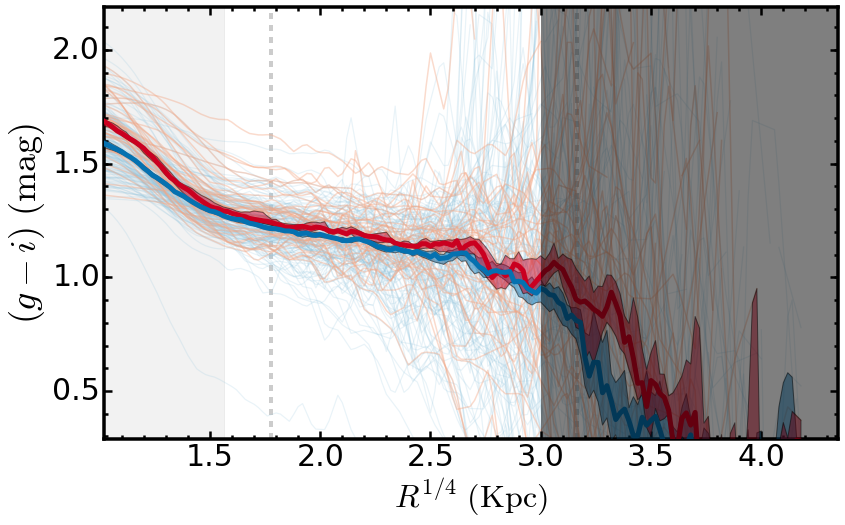

In [141]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [-5.0, -5.0], [5.0, 5.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax1.fill_between([3.0, 4.5], [-2.0, -2.0], [3.0, 3.0], 
                 facecolor='k', edgecolor='none', alpha=0.5, zorder=2000)

for ggi in gm_sgi:
    ax1.plot(RSMA_COMMON, ggi, c=BLUE0, alpha=0.20, linewidth=1.2)
for bgi in bm_sgi:
    ax1.plot(RSMA_COMMON, bgi, c=RED0, alpha=0.40, linewidth=1.5)

ax1.fill_between(RSMA_COMMON, gm_mgi[0], gm_mgi[1], 
                 facecolor=BLUE1, alpha=0.5, zorder=1005)
ax1.fill_between(RSMA_COMMON, bm_mgi[0], bm_mgi[1], 
                 facecolor=RED1, alpha=0.5, zorder=1005)
                 
ax1.plot(RSMA_COMMON, bm_mgi[2], linestyle='-', linewidth=5.0, 
         c=RED1, alpha=1.0, zorder=1010)
ax1.plot(RSMA_COMMON, gm_mgi[2], linestyle='-', linewidth=5.0, 
         c=BLUE1, alpha=1.0, zorder=1010)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=32)
ax1.set_ylabel('$(g-i)\ \mathrm{(mag)}$', size=36)

ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(0.29, 2.19)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#ax1.text(0.50, 0.84, '$11.5 < \log (M_{\star}) < 11.7$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=30.0, transform=ax1.transAxes)

plt.show()

#fig.savefig('../figure/hscMassive_cprof_m1_test.png', dpi=230)

In [134]:
# GAMA M1a 
gm_sgr, gm_mgr, gm_agr, gm_dgr = organizeSbp(prof_gama_ma, 
                                             col1='muG3', col2='muR3', kind='color',
                                             col3='KCORRECT_c_G', col4='KCORRECT_c_R', 
                                             sun1=amag_sun_des_g, sun2=amag_sun_des_r)
# BCG M1a 
bm_sgr, bm_mgr, bm_agr, bm_dgr = organizeSbp(prof_bcg_ma, 
                                             col1='muG3', col2='muR3', kind='color',
                                             col3='KCORRECT_c_G', col4='KCORRECT_c_R', 
                                             sun1=amag_sun_des_g, sun2=amag_sun_des_r)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:249: RuntimeWarning: invalid value encountered in subtract


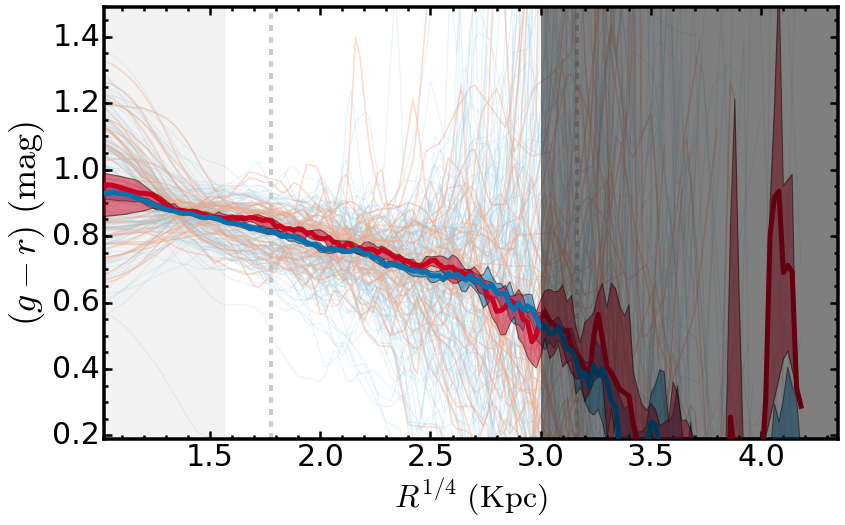

In [144]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [-5.0, -5.0], [5.0, 5.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax1.fill_between([3.0, 4.5], [-2.0, -2.0], [3.0, 3.0], 
                 facecolor='k', edgecolor='none', alpha=0.5, zorder=2000)

for ggr in gm_sgr:
    ax1.plot(RSMA_COMMON, ggr, c=BLUE0, alpha=0.20, linewidth=1.2)
for bgr in bm_sgr:
    ax1.plot(RSMA_COMMON, bgr, c=RED0, alpha=0.40, linewidth=1.5)

ax1.fill_between(RSMA_COMMON, gm_mgr[0], gm_mgr[1], 
                 facecolor=BLUE1, alpha=0.5, zorder=1005)
ax1.fill_between(RSMA_COMMON, bm_mgr[0], bm_mgr[1], 
                 facecolor=RED1, alpha=0.5, zorder=1005)
                 
ax1.plot(RSMA_COMMON, bm_mgr[2], linestyle='-', linewidth=5.0, 
         c=RED1, alpha=1.0, zorder=1010)
ax1.plot(RSMA_COMMON, gm_mgr[2], linestyle='-', linewidth=5.0, 
         c=BLUE1, alpha=1.0, zorder=1010)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=32)
ax1.set_ylabel('$(g-r)\ \mathrm{(mag)}$', size=36)

ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(0.19, 1.49)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#ax1.text(0.50, 0.84, '$11.5 < \log (M_{\star}) < 11.7$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=30.0, transform=ax1.transAxes)

plt.show()

#fig.savefig('../figure/hscMassive_cprof_m1_test.png', dpi=230)

In [139]:
# GAMA M1a 
gm_sgz, gm_mgz, gm_agz, gm_dgz = organizeSbp(prof_gama_ma, 
                                             col1='muG3', col2='muZ3', kind='color',
                                             col3='KCORRECT_c_G', col4='KCORRECT_c_Z', 
                                             sun1=amag_sun_des_g, sun2=amag_sun_des_z)
# BCG M1a 
bm_sgz, bm_mgz, bm_agz, bm_dgz = organizeSbp(prof_bcg_ma, 
                                             col1='muG3', col2='muZ3', kind='color',
                                             col3='KCORRECT_c_G', col4='KCORRECT_c_Z', 
                                             sun1=amag_sun_des_g, sun2=amag_sun_des_z)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:249: RuntimeWarning: invalid value encountered in subtract


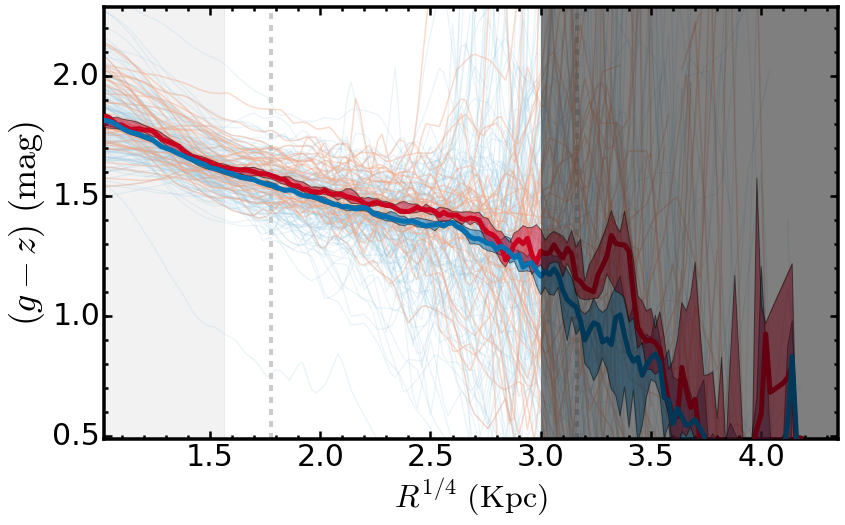

In [143]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [-5.0, -5.0], [5.0, 5.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax1.fill_between([3.0, 4.5], [-2.0, -2.0], [3.0, 3.0], 
                 facecolor='k', edgecolor='none', alpha=0.5, zorder=2000)

for ggz in gm_sgz:
    ax1.plot(RSMA_COMMON, ggz, c=BLUE0, alpha=0.20, linewidth=1.2)
for bgz in bm_sgz:
    ax1.plot(RSMA_COMMON, bgz, c=RED0, alpha=0.40, linewidth=1.5)

ax1.fill_between(RSMA_COMMON, gm_mgz[0], gm_mgz[1], 
                 facecolor=BLUE1, alpha=0.5, zorder=1005)
ax1.fill_between(RSMA_COMMON, bm_mgz[0], bm_mgz[1], 
                 facecolor=RED1, alpha=0.5, zorder=1005)
                 
ax1.plot(RSMA_COMMON, bm_mgz[2], linestyle='-', linewidth=5.0, 
         c=RED1, alpha=1.0, zorder=1010)
ax1.plot(RSMA_COMMON, gm_mgz[2], linestyle='-', linewidth=5.0, 
         c=BLUE1, alpha=1.0, zorder=1010)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=32)
ax1.set_ylabel('$(g-z)\ \mathrm{(mag)}$', size=36)

ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(0.49, 2.29)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#ax1.text(0.50, 0.84, '$11.5 < \log (M_{\star}) < 11.7$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=30.0, transform=ax1.transAxes)

plt.show()

#fig.savefig('../figure/hscMassive_cprof_m1_test.png', dpi=230)

# Whole Sample; Using M10

## Using Mass Model C

In [145]:
# Sample Matching Using K-Dtree

## Mass and Redshift Limit 
mlim0, mlim1 = 11.45, 11.95
zlim0, zlim1 = 0.20, 0.48
lamLimit = 30
pcenLimit = 0.8

## BCG sample used for matching
bcgUse = bcgClean[(bcgClean['m100_c'] >= mlim0) & 
                  (bcgClean['m100_c'] <= mlim1) & 
                  (bcgClean['z_use'] >= zlim0) &
                  (bcgClean['z_use'] <= zlim1) &
                  (bcgClean['LAMBDA_CLUSTER'] >= lamLimit) &
                  (bcgClean['P_CEN_1'] >= pcenLimit)]
print("# BCG Sample Size: ", len(bcgUse))

## GAMA sample used for matching
gamaUse = gamaClean[(gamaClean['m100_c'] >= (mlim0 + 0.005)) & 
                    (gamaClean['m100_c'] <= (mlim1 + 0.05)) & 
                    (gamaClean['z_use'] >= (zlim0 - 0.01)) &
                    (gamaClean['z_use'] <= (zlim1 + 0.01))]
print("# GAMA Sample Size: ", len(gamaUse))

## Isolate the parameters used for matching 
bcgZM1 = np.stack((np.asarray(bcgUse[bcgUse['m100_c'] <= 12.65]['m10_c']), 
                   np.asarray(bcgUse[bcgUse['m100_c'] <= 12.65]['m5_c']),
                   np.asarray(bcgUse[bcgUse['m100_c'] <= 12.65]['m15_c']),
                   np.asarray(bcgUse[bcgUse['m100_c'] <= 12.65]['gi_kC']),
                   np.asarray(bcgUse[bcgUse['m100_c'] <= 12.65]['z_use'])), axis=-1)
#bcgZM2 = np.stack((np.asarray(bcgUse[bcgUse['m100_c'] > 11.65]['m100_c']), 
#                   np.asarray(bcgUse[bcgUse['m100_c'] > 11.65]['m15_c']),
#                   np.asarray(bcgUse[bcgUse['m100_c'] > 11.65]['gi_kC']),
#                   np.asarray(bcgUse[bcgUse['m100_c'] > 11.65]['z_use'])), axis=-1)

gamaZM = np.stack((np.asarray(gamaUse['m10_c']),
                   np.asarray(gamaUse['m5_c']),
                   np.asarray(gamaUse['m15_c']),
                   np.asarray(gamaUse['gi_kC']), 
                   np.asarray(gamaUse['z_use'])), axis=-1)

## Build the Tree
gamaTree = KDTree(gamaZM, leaf_size=5)  

dist, ind1 = gamaTree.query(bcgZM1, k=5) 
print("# Matched < 11.65", len(ind1.ravel()))
#dist, ind2 = gamaTree.query(bcgZM2, k=7) 
#print("# Matched > 11.65", len(ind2.ravel()))

#indAll = np.hstack([ind1.ravel(), ind2.ravel()])
indAll = ind1.ravel()
indUni = np.unique(indAll)
print("# All and Unique Matched Sample", len(indAll), len(indUni))

gamaMatch = gamaUse[indAll]
gamaUnique = gamaUse[indUni]

# BCG Sample Size:  45
# GAMA Sample Size:  922
# Matched < 11.65 225
# All and Unique Matched Sample 225 174


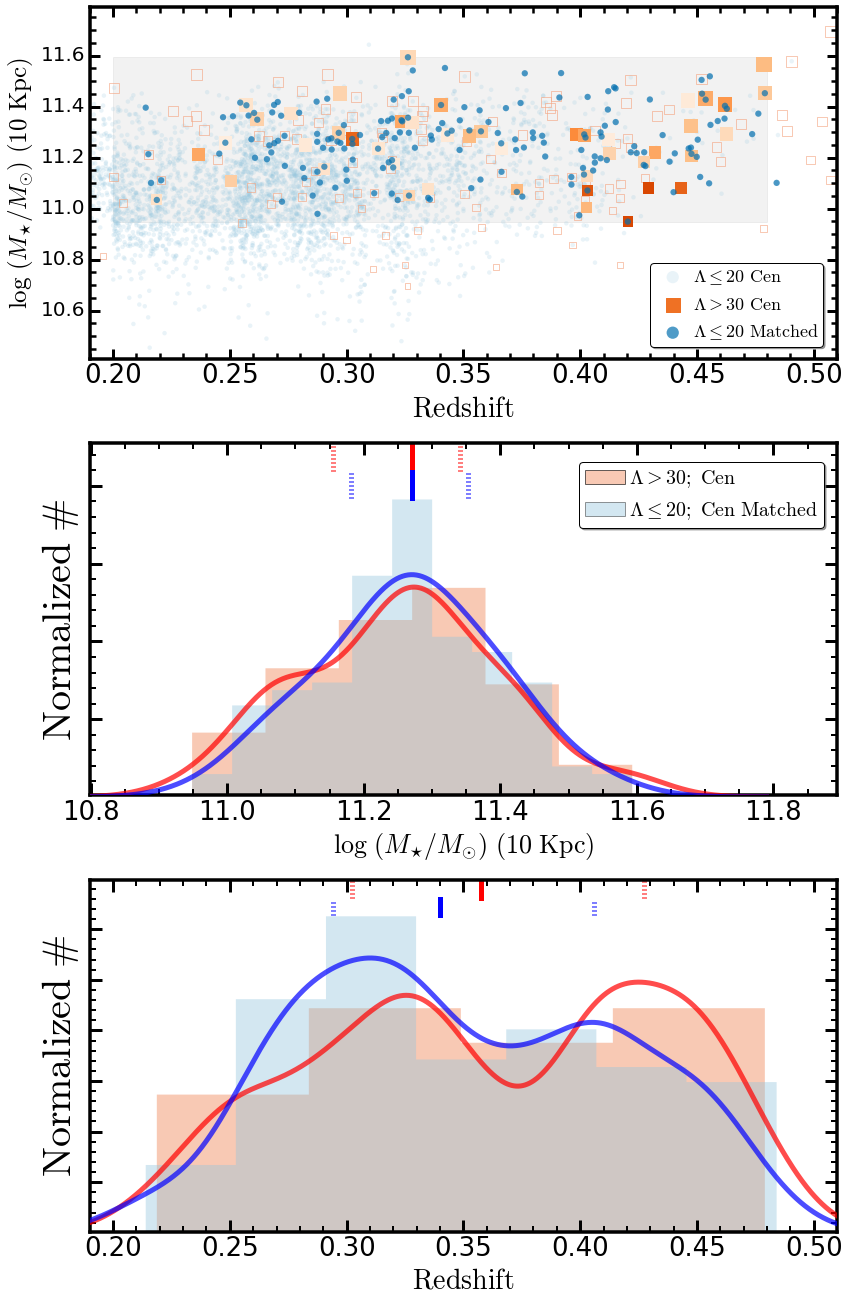

In [147]:
fig1 = plt.figure(figsize=(12, 18))
fig1.subplots_adjust(left=0.12, right=0.985, wspace=0.05,
                     bottom=0.05, top=0.995, hspace=0.24)

## Mass and Redshift limits
mmin, mmax = 10.41, 11.79
zmin, zmax = 0.19, 0.51

mx = np.linspace(mmin, mmax, 1000)
zx = np.linspace(zmin, zmax, 1000)

# ------------------------------------------------------------------------------------------------------#
# Redshift - Mass plot 
ax1 = fig1.add_subplot(311)

## Mass limits 
m10_0, m10_1 = np.nanmin(bcgUse['m10_c']), np.nanmax(bcgUse['m10_c'])
ax1.fill_between([zlim0, zlim1], [m10_0, m10_0], [m10_1, m10_1],
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)

## GAMA sample
p1 = ax1.scatter(gamaClean['z_use'], gamaClean['m10_c'], 
                 alpha=0.20, facecolor=BLUE0, edgecolor='none', 
                 label='$\Lambda \leq 20\ \mathrm{Cen}$')
## BCG sample
p2 = ax1.scatter(bcgClean['z_use'], bcgClean['m10_c'], 
                 facecolor='none', s=((bcgClean['m10_c'] - 10.40) * 100.0), 
                 cmap=ORG4, alpha=0.60, marker='s',
                 edgecolor=RED0, label=None)

p3 = ax1.scatter(bcgUse['z_use'], bcgUse['m10_c'], 
                 edgecolor='none', s=((bcgUse['m10_c'] - 10.40) * 200.0), 
                 cmap=ORG4, alpha=1.00, 
                 c=toColorArr(bcgUse['LAMBDA_CLUSTER'], bottom=20.0, top=70.0), 
                 label='$\Lambda > 30\ \mathrm{Cen}$', marker='s')

## Matched GAMA sample
p4 = ax1.scatter(gamaUnique['z_use'], gamaUnique['m10_c'], 
                 alpha=0.70, facecolor=BLUE1, edgecolor='none', s=40,
                 label='$\Lambda \leq 20\ \mathrm{Matched}$')

## Legend
ax1.legend(loc=(0.75, 0.035), shadow=True, fancybox=True, 
           numpoints=1, fontsize=18, scatterpoints=1, 
           markerscale=0.9, borderpad=0.25, handletextpad=0.1)
legend = ax1.get_legend()
legend.legendHandles[1].set_color(ORG4(0.8))
legend.legendHandles[0].set_sizes([150])
legend.legendHandles[1].set_sizes([200])
legend.legendHandles[2].set_sizes([150])

## Axes setup
### Minor Ticks on 
ax1.minorticks_on()
### Axes Thickness
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3.5)

##  Tick Label Size 
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    
## Tick Length and Width
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

## Label
ax1.set_xlabel('$\mathrm{Redshift}$', size=28)
ax1.set_ylabel('$\log\ (M_{\star}/M_{\odot})\ (10\ \mathrm{Kpc})$', 
               size=25)

## Axis limits
ax1.set_xlim(zmin, zmax)
ax1.set_ylim(mmin, mmax)

# ------------------------------------------------------------------------------------------------------#
# Mass Plot 
ax2 = fig1.add_subplot(312)

## KDE for BCG 
bcgMKde = KernelDensity(0.06, kernel='gaussian')
bcgMKde.fit(bcgUse['m10_c'][:, None])
bcgMDens = np.exp(bcgMKde.score_samples(mx[:, None]))

## KDE for GAMA
gamaMKde = KernelDensity(0.06, kernel='gaussian')
gamaMKde.fit(gamaUnique['m10_c'][:, None])
gamaMDens = np.exp(gamaMKde.score_samples(mx[:, None]))

## Histogram 
aa, _, _ = hist(bcgUse['m10_c'], bins='knuth', ax=ax2, normed=True, zorder=1,
                histtype='stepfilled', edgecolor='none', facecolor=RED0, 
                alpha=0.6, label='$\Lambda > 30;\ \mathrm{Cen}$')
bb, _, _ = hist(gamaUnique['m10_c'], bins='knuth', ax=ax2, normed=True, zorder=1,
                histtype='stepfilled', edgecolor='none', facecolor=BLUE0, 
                alpha=0.4, label='$\Lambda \leq 20;\ \mathrm{Cen\ Matched}$')

## Density plot 
ax2.plot(mx, bcgMDens, '-', color='r', zorder=3, linewidth=5.0, alpha=0.7)
ax2.plot(mx, gamaMDens, '-', color='b', zorder=3, linewidth=5.0, alpha=0.7)

## X, Y Limits
ax2.set_xlim(m10_0-0.15, m10_1+0.30)
ylim = np.nanmax(np.hstack([aa, bb])) + 0.72
ax2.set_ylim(0.02, ylim)

## Legend
ax2.legend(loc=(0.655, 0.76), shadow=True, fancybox=True, 
           numpoints=1, fontsize=20, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.2)

## X, Y Lables
ax2.set_xlabel('$\log\ (M_{\star}/M_{\odot})\ (\mathrm{10\ Kpc})$', size=26)
ax2.set_ylabel('$\mathrm{Normalized\ \#}$', size=40)

## Highlight the median 
### BCG
ax2.plot([np.nanmedian(bcgUse['m10_c']), np.nanmedian(bcgUse['m10_c'])],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r')
ax2.plot([np.percentile(bcgUse['m10_c'], 25), 
          np.percentile(bcgUse['m10_c'], 25)],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r', linestyle=':')
ax2.plot([np.percentile(bcgUse['m10_c'], 75), 
          np.percentile(bcgUse['m10_c'], 75)],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r', linestyle=':')
### GAMA
ax2.plot([np.nanmedian(gamaUnique['m10_c']), np.nanmedian(gamaUnique['m10_c'])],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b')
ax2.plot([np.percentile(gamaUnique['m10_c'], 25), 
          np.percentile(gamaUnique['m10_c'], 25)],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b', linestyle=':')
ax2.plot([np.percentile(gamaUnique['m10_c'], 75), 
          np.percentile(gamaUnique['m10_c'], 75)],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b', linestyle=':')

## Ticks
ax2.minorticks_on()
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
ax2.tick_params('both', length=12, width=3, which='major')
ax2.tick_params('both', length=6, width=2, which='minor')
ax2.yaxis.set_major_formatter(NullFormatter())

## Width of the axes
ax2.spines['top'].set_linewidth(3.5)
ax2.spines['right'].set_linewidth(3.5)
ax2.spines['bottom'].set_linewidth(3.5)
ax2.spines['left'].set_linewidth(3.5)

# ------------------------------------------------------------------------------------------------------#
# Redshift Plot 
ax3 = fig1.add_subplot(313)

## KDE for BCG 
bcgMKde = KernelDensity(0.02, kernel='gaussian')
bcgMKde.fit(bcgUse['z_use'][:, None])
bcgMDens = np.exp(bcgMKde.score_samples(zx[:, None]))

## KDE for GAMA
gamaMKde = KernelDensity(0.02, kernel='gaussian')
gamaMKde.fit(gamaUnique['z_use'][:, None])
gamaMDens = np.exp(gamaMKde.score_samples(zx[:, None]))

## Histogram 
aa, _, _ = hist(bcgUse['z_use'], bins='knuth', ax=ax3, normed=True, zorder=1,
                histtype='stepfilled', edgecolor='none', facecolor=RED0, 
                alpha=0.6)
bb, _, _ = hist(gamaUnique['z_use'], bins='knuth', ax=ax3, normed=True, zorder=1,
                histtype='stepfilled', edgecolor='none', facecolor=BLUE0, 
                alpha=0.4)

## Density plot 
ax3.plot(zx, bcgMDens, '-', color='r', zorder=3, linewidth=5.0, alpha=0.7)
ax3.plot(zx, gamaMDens, '-', color='b', zorder=3, linewidth=5.0, alpha=0.7)

## X, Y Limits
ax3.set_xlim(zmin, zmax)
ylim = np.nanmax(np.hstack([aa, bb])) + 0.72
ax3.set_ylim(0.02, ylim)

## X, Y Lables
ax3.set_xlabel('$\mathrm{Redshift}$', size=28)
ax3.set_ylabel('$\mathrm{Normalized\ \#}$', size=40)

## Highlight the median 
### BCG
ax3.plot([np.nanmedian(bcgUse['z_use']), np.nanmedian(bcgUse['z_use'])],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r')
ax3.plot([np.percentile(bcgUse['z_use'], 25), 
          np.percentile(bcgUse['z_use'], 25)],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r', linestyle=':')
ax3.plot([np.percentile(bcgUse['z_use'], 75), 
          np.percentile(bcgUse['z_use'], 75)],
         [ylim-0.35, ylim-0.02], linewidth=5.0, c='r', linestyle=':')
### GAMA
ax3.plot([np.nanmedian(gamaUnique['z_use']), np.nanmedian(gamaUnique['z_use'])],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b')
ax3.plot([np.percentile(gamaUnique['z_use'], 25), 
          np.percentile(gamaUnique['z_use'], 25)],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b', linestyle=':')
ax3.plot([np.percentile(gamaUnique['z_use'], 75), 
          np.percentile(gamaUnique['z_use'], 75)],
         [ylim-0.70, ylim-0.37], linewidth=5.0, c='b', linestyle=':')

## Ticks
ax3.minorticks_on()
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
ax3.tick_params('both', length=12, width=3, which='major')
ax3.tick_params('both', length=6, width=2, which='minor')
ax3.yaxis.set_major_formatter(NullFormatter())

## Width of the axes
ax3.spines['top'].set_linewidth(3.5)
ax3.spines['right'].set_linewidth(3.5)
ax3.spines['bottom'].set_linewidth(3.5)
ax3.spines['left'].set_linewidth(3.5)

# ------------------------------------------------------------------------------------------------------#

plt.show()

fig1.savefig('../figure/hscMassive_matchAll_m10_1a.png', dpi=230)

In [153]:
# Organize the sample
prof_bcg_m10 = getStackProfiles(bcgUse, bcgDir, name='test_bcg_matchTot_m10_1')

prof_gama_m10 = getStackProfiles(gamaUnique, gamaDir, name='test_gamaTot_m10_1')

# Median profiles
bm_sm, bm_mm, bm_amg, bm_stdm = organizeSbp(prof_bcg_m10, col1='muI1', 
                                            col2='LOGM2LI_C', kind='mass')
gu_sm, gu_mm, gu_amg, gu_stdm = organizeSbp(prof_gama_m10, col1='muI1', 
                                            col2='LOGM2LI_C', kind='mass')
# Larger mask
bm_sm_b, bm_mm_b, bm_amg_b, bm_stdm_b = organizeSbp(prof_bcg_m10, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass')
gu_sm_b, gu_mm_b, gu_amg_b, gu_stdm_b = organizeSbp(prof_gama_m10, col1='muI3', 
                                                    col2='LOGM2LI_C', kind='mass')
# Random mix sample 
mixM_sm = np.vstack([gu_sm, bm_sm])
randM_sm = []
ii = 0
while ii < 8000:
    mprof = np.nanmedian(mixM_sm[np.random.choice(len(mixM_sm), len(bm_sm), 
                                                   replace=False)], axis=0)
    randM_sm.append(mprof)
    ii += 1 
    
# Integration
indInt = np.where((RSMA_COMMON ** 4.0) <= 101.01)

isoArea = (np.pi * ((RSMA_COMMON[indInt] ** 4.0) ** 2.0) * 0.95)
isoRing = np.append(isoArea[0], [isoArea[1:] - isoArea[:-1]])
print(np.log10(np.nansum(10.0 ** bm_mm[2][indInt] * isoRing)))
print(np.log10(np.nansum(10.0 ** gu_mm[2][indInt] * isoRing)))

## Sample test_bcg_matchTot_m10_1 : Will deal with 45 galaxies

## Save test_bcg_matchTot_m10_1 to /Users/songhuang/work/hscs/gama_massive/sbp/redbcg/test_bcg_matchTot_m10_1_profs.pkl
## Sample test_gamaTot_m10_1 : Will deal with 174 galaxies

## Save test_gamaTot_m10_1 to /Users/songhuang/work/hscs/gama_massive/sbp/gama/test_gamaTot_m10_1_profs.pkl
11.3763195732
11.3155253726


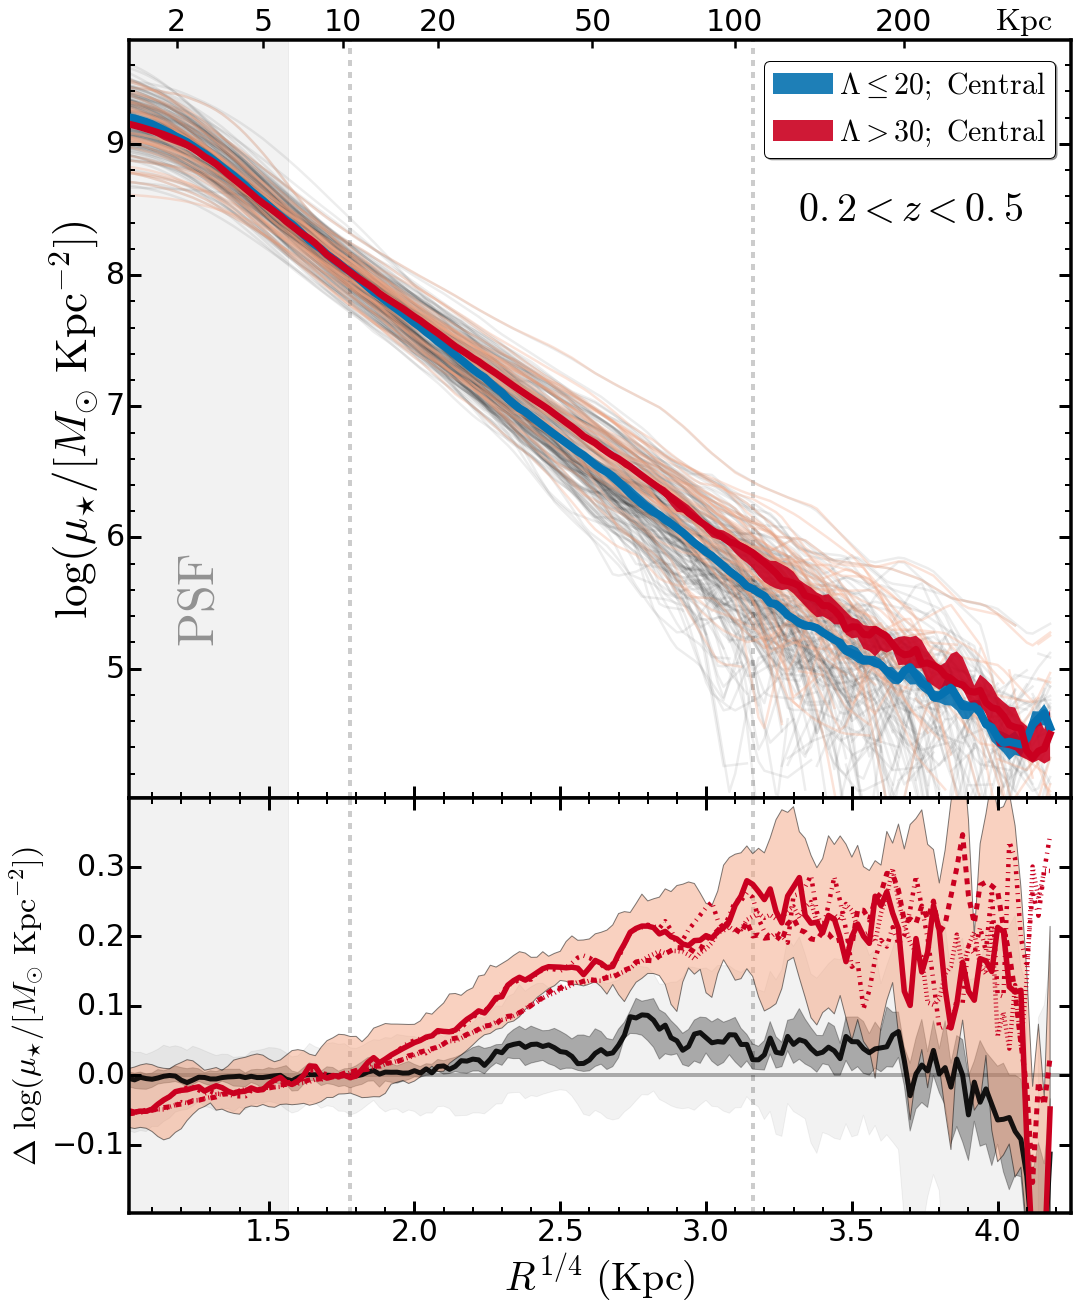

In [149]:
# --------------------------------------------------------------------------------------- #
## Setup up figure
fig2 = plt.figure(figsize=(15, 18))

ax1 = plt.axes(SBP2)
ax3 = plt.axes(SBP1)

########################################################################################
## Region affected by PSF
# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [2.0, 2.0], [11.0, 11.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
## Mark the two interesting radius
# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

########################################################################################
## Individual profiles
for gg in gu_sm:
    ax1.plot(RSMA_COMMON, gg, c='k', alpha=0.07, linewidth=2.5)
for bb in bm_sm:
    ax1.plot(RSMA_COMMON, bb, c=RED0, alpha=0.30, linewidth=2.5)

## Median profiles
ax1.fill_between(RSMA_COMMON, gu_mm[0], gu_mm[1], 
                 facecolor=BLUE1, edgecolor='none', alpha=0.9, 
                 zorder=1005, label="$\Lambda \leq 20;\ \mathrm{Central}$")
ax1.fill_between(RSMA_COMMON, bm_mm[0], bm_mm[1], 
                 facecolor=RED1, edgecolor='none', alpha=0.9, 
                 zorder=1005, label="$\Lambda > 30;\ \mathrm{Central}$")

ax1.plot(RSMA_COMMON, gu_mm[2], linestyle='-', linewidth=8.0, 
         c=BLUE1, alpha=1.0, zorder=1010)
ax1.plot(RSMA_COMMON, bm_mm[2], linestyle='-', linewidth=7.0, 
         c=RED1, alpha=1.0, zorder=1010)

## X, Y Lables
ax1.set_ylabel('$\log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=45)

## Ticks
ax1.minorticks_on()
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax1.tick_params('both', length=12, width=3, which='major')
ax1.tick_params('both', length=6, width=2, which='minor')

## Remove the X-axis label
ax1.xaxis.set_major_formatter(NullFormatter())

## Width of the axes
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

## Label the PSF region 
ax1.text(0.05, 0.20, '$\mathrm{PSF}$', rotation='vertical',
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=50.0, transform=ax1.transAxes, weight='bold', 
         color='k', alpha=0.4)


## Label the PSF region 
ax1.text(0.83, 0.75, '$0.2 < z < 0.5$', 
         verticalalignment='bottom', horizontalalignment='center',
         fontsize=40.0, transform=ax1.transAxes, weight='bold', 
         color='k')

## Legend
ax1.legend(loc=(0.675, 0.845), shadow=True, fancybox=True, 
           numpoints=1, fontsize=30, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.2)

## X, Y limits
ax1.set_xlim(1.02, 4.25)
ax1.set_ylim(4.01, 9.79)

########################################################################################
## Secondary Axis 
ax2 = ax1.twiny()
kpcs = np.asarray([2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0])
kpcTicks= (kpcs ** 0.25)
ax2.set_xlim(1.02, 4.35)
ax2.set_ylim(4.01, 9.79)
ax2.set_xticks(kpcTicks)
ax2.set_xticklabels(['{:g}'.format(kpc) for kpc in kpcs], fontsize=30)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax2.text(0.92, 1.0035, '$\mathrm{Kpc}$', 
         verticalalignment='bottom', horizontalalignment='left',
         fontsize=32.0, transform=ax2.transAxes)

########################################################################################

## Highlight zero 
ax3.axhline(0.0, linewidth=4.0, c='k', linestyle='-', zorder=0, alpha=0.3)

### 10 Kpc 
ax3.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
### 100 Kpc
ax3.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

### z = 0.4 : 1"=5.4 Kpc
ax3.fill_between([0.0, 6.0**0.25], [-2.0, -2.0], [2.0, 2.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)

## Random Mixed Sample
ax3.fill_between(RSMA_COMMON, 
                 np.percentile(randM_sm - gu_mm[2], 3, axis=0), 
                 np.percentile(randM_sm - gu_mm[2], 97, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax3.fill_between(RSMA_COMMON, 
                 np.percentile(randM_sm - gu_mm[2], 31, axis=0), 
                 np.percentile(randM_sm - gu_mm[2], 69, axis=0), 
                 facecolor='k', edgecolor='k', alpha=0.30, zorder=0)

ax3.plot(RSMA_COMMON, np.percentile(randM_sm - gu_mm[2], 50, axis=0), 
         c='k', linewidth=5.0, linestyle='-', alpha=0.9)

## BCG-GAMA
ax3.fill_between(RSMA_COMMON, 
                 (bm_mm[0] - gu_mm[1]), (bm_mm[1] - gu_mm[0]),
                 facecolor=RED0, edgecolor='k', alpha=0.50, zorder=1)

ax3.plot(RSMA_COMMON, bm_mm[2] - gu_mm[2], c=RED1, linewidth=5.5, 
         linestyle='-')
ax3.plot(RSMA_COMMON, bm_amg[2] - gu_amg[2], c=RED1, linewidth=5.0, 
         linestyle='--')

ax3.plot(RSMA_COMMON, bm_mm_b[2] - gu_mm_b[2], c=RED1, linewidth=4.5, 
         linestyle='-.')
ax3.plot(RSMA_COMMON, bm_amg_b[2] - gu_amg_b[2], c=RED1, linewidth=4.5, 
         linestyle=':')

ax3.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=40)
ax3.set_ylabel('$\Delta\ \log ({\mu}_{\star}/[M_{\odot}\ \mathrm{Kpc}^{-2}])$', size=32)

## X, Y Limits
ax3.set_xlim(1.02, 4.25)
ax3.set_ylim(-0.199, 0.399)

## Axes setup
### Minor Ticks on 
ax3.minorticks_on()
ax3.tick_params(axis='y', which='minor', left='off', right='off')

for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
ax3.tick_params('both', length=12, width=3, which='major')
ax3.tick_params('both', length=6, width=2, which='minor')

ax3.spines['top'].set_linewidth(3.5)
ax3.spines['right'].set_linewidth(3.5)
ax3.spines['bottom'].set_linewidth(3.5)
ax3.spines['left'].set_linewidth(3.5)

########################################################################################
plt.show()

fig2.savefig('../figure/hscMassive_matchAll_m10_1b.png', dpi=230)

In [154]:
# GAMA M1a 
gm_sgr, gm_mgr, gm_agr, gm_dgr = organizeSbp(prof_gama_m10, 
                                             col1='muG3', col2='muR3', kind='color',
                                             col3='KCORRECT_c_G', col4='KCORRECT_c_R', 
                                             sun1=amag_sun_des_g, sun2=amag_sun_des_r)
# BCG M1a 
bm_sgr, bm_mgr, bm_agr, bm_dgr = organizeSbp(prof_bcg_m10, 
                                             col1='muG3', col2='muR3', kind='color',
                                             col3='KCORRECT_c_G', col4='KCORRECT_c_R', 
                                             sun1=amag_sun_des_g, sun2=amag_sun_des_r)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:249: RuntimeWarning: invalid value encountered in subtract


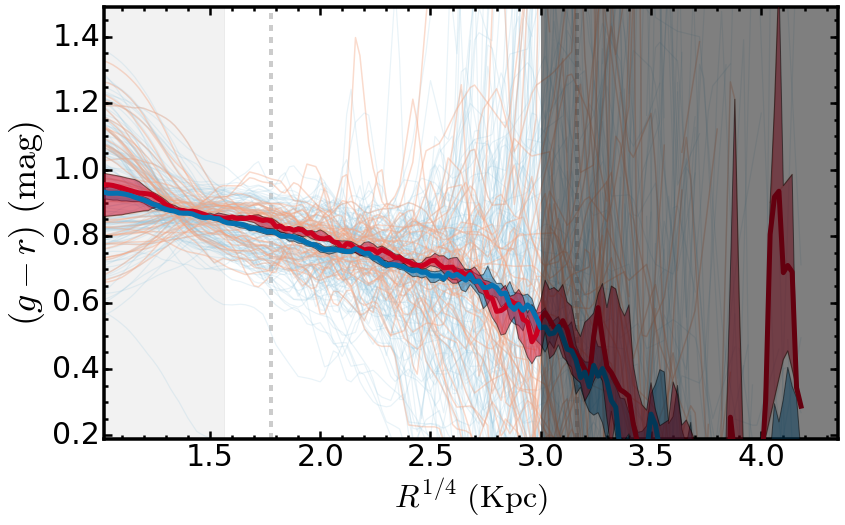

In [155]:
# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)
ax1.minorticks_on()

# 10 Kpc 
ax1.axvline(10.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)
# 100 Kpc
ax1.axvline(100.0 ** 0.25, linewidth=4.0, c='k', linestyle='--', zorder=0, alpha=0.2)

# z = 0.4 : 1"=5.4 Kpc
ax1.fill_between([0.0, 6.0**0.25], [-5.0, -5.0], [5.0, 5.0], 
                 facecolor='k', edgecolor='k', alpha=0.05, zorder=0)
ax1.fill_between([3.0, 4.5], [-2.0, -2.0], [3.0, 3.0], 
                 facecolor='k', edgecolor='none', alpha=0.5, zorder=2000)

for ggr in gm_sgr:
    ax1.plot(RSMA_COMMON, ggr, c=BLUE0, alpha=0.20, linewidth=1.2)
for bgr in bm_sgr:
    ax1.plot(RSMA_COMMON, bgr, c=RED0, alpha=0.40, linewidth=1.5)

ax1.fill_between(RSMA_COMMON, gm_mgr[0], gm_mgr[1], 
                 facecolor=BLUE1, alpha=0.5, zorder=1005)
ax1.fill_between(RSMA_COMMON, bm_mgr[0], bm_mgr[1], 
                 facecolor=RED1, alpha=0.5, zorder=1005)
                 
ax1.plot(RSMA_COMMON, bm_mgr[2], linestyle='-', linewidth=5.0, 
         c=RED1, alpha=1.0, zorder=1010)
ax1.plot(RSMA_COMMON, gm_mgr[2], linestyle='-', linewidth=5.0, 
         c=BLUE1, alpha=1.0, zorder=1010)

ax1.set_xlabel('$R^{1/4}\ (\mathrm{Kpc})$', size=32)
ax1.set_ylabel('$(g-r)\ \mathrm{(mag)}$', size=36)

ax1.set_xlim(1.02, 4.35)
ax1.set_ylim(0.19, 1.49)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#ax1.text(0.50, 0.84, '$11.5 < \log (M_{\star}) < 11.7$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=30.0, transform=ax1.transAxes)

plt.show()

#fig.savefig('../figure/hscMassive_cprof_m1_test.png', dpi=230)